In [1]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 95%; }
</style>
"""))

In [2]:
from urllib.parse import quote_plus
import sqlalchemy as sa
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mc # For the legend
from matplotlib.cm import ScalarMappable
import seaborn as sns
import re
import numbers
%matplotlib inline
import boto3
import pickle
import time
import math

import datetime
from datetime import timedelta 
import matplotlib.dates as mdates

## Workflow

Below is the existing workflow for Scout load shape runs and data processing. As requirements have been added (such as adding output building type runs), there hasn't been much oppurtunity to build out features on the resstock branch, so results are sort of disjointed, and requires multiple runs and therefore multiple queries.

1. Simulate 3 ResStock runs, 1 each for SF, mobile-home, and MF (by updating the building type tsv) upload timeseries to AWS
2. Run 5 queries for each of the building types (4 baselines and 1 upgrade), queries shown in the subsection below
3. Save timeseries csv output locally
4. Run the `Read Timeseries Data` blocks to import data, get peak/take hours, and set baseline mapping
5. Optional: run spot checks on the imported data with the `Spot Checks` code (we have another script that checks the post-processed data
6. Run the `Write Output CSVs` code to write loads in correct format
7. Run Spot_check_figures.ipynb to generate figures based on the output csvs, which helps check for potential issues in the ResStock run and this post-processing script.

### Athena Queries

#### BASELINE - All
SELECT sum(1) AS "count",
         "full_v250_mh_timeseries"."time",
         "full_v250_mh_baseline"."build_existing_model.location_city" AS "city",
		 "full_v250_mh_baseline"."build_existing_model.geometry_building_type_recs_map" AS "building_type",
         "full_v250_mh_timeseries"."upgrade",
         avg("full_v250_mh_timeseries"."electricity_heating_kwh") AS "electricity_heating_kwh",
         avg("full_v250_mh_timeseries"."electricity_cooling_kwh") AS "electricity_cooling_kwh",
         avg("full_v250_mh_timeseries"."electricity_interior_lighting_kwh") AS "electricity_interior_lighting_kwh",
         avg("full_v250_mh_timeseries"."electricity_fans_heating_kwh") AS "electricity_fans_heating_kwh",
         avg("full_v250_mh_timeseries"."electricity_fans_cooling_kwh") AS "electricity_fans_cooling_kwh",
         avg("full_v250_mh_timeseries"."electricity_pumps_heating_kwh") AS "electricity_pumps_heating_kwh",
         avg("full_v250_mh_timeseries"."electricity_pumps_cooling_kwh") AS "electricity_pumps_cooling_kwh",
         avg("full_v250_mh_timeseries"."electricity_water_systems_kwh") AS "electricity_water_systems_kwh",
         avg("full_v250_mh_timeseries"."electricity_refrigerator_kwh") AS "electricity_refrigerator_kwh",
         avg("full_v250_mh_timeseries"."electricity_clothes_washer_kwh") AS "electricity_clothes_washer_kwh",
         avg("full_v250_mh_timeseries"."electricity_clothes_dryer_kwh") AS "electricity_clothes_dryer_kwh",
         avg("full_v250_mh_timeseries"."electricity_dishwasher_kwh") AS "electricity_dishwasher_kwh",
         avg("full_v250_mh_timeseries"."electricity_plug_loads_kwh") AS "electricity_plug_loads_kwh",
         avg("full_v250_mh_timeseries"."electricity_pool_heater_kwh") AS "electricity_pool_heater_kwh",
         avg("full_v250_mh_timeseries"."electricity_pool_pump_kwh") AS "electricity_pool_pump_kwh"
FROM "full_v250_mh_timeseries"
JOIN "full_v250_mh_baseline"
    ON "full_v250_mh_timeseries"."building_id" = "full_v250_mh_baseline"."building_id"
WHERE "full_v250_mh_timeseries"."upgrade" = '0'
GROUP BY  "full_v250_mh_timeseries"."time", "full_v250_mh_baseline"."build_existing_model.location_city", "full_v250_mh_baseline"."build_existing_model.geometry_building_type_recs_map", "full_v250_mh_timeseries"."upgrade"
ORDER BY  "full_v250_mh_timeseries"."upgrade", "full_v250_mh_baseline"."build_existing_model.location_city", "full_v250_mh_baseline"."build_existing_model.geometry_building_type_recs_map", "full_v250_mh_timeseries"."time"

#### BASELINE - CAC
SELECT sum(1) AS "count",
         "full_v250_mh_timeseries"."time",
         "full_v250_mh_baseline"."build_existing_model.location_city" AS "city",
		 "full_v250_mh_baseline"."build_existing_model.geometry_building_type_recs_map" AS "building_type",
         "full_v250_mh_timeseries"."upgrade",
         avg("full_v250_mh_timeseries"."electricity_heating_kwh") AS "electricity_heating_kwh",
         avg("full_v250_mh_timeseries"."electricity_cooling_kwh") AS "electricity_cooling_kwh",
         avg("full_v250_mh_timeseries"."electricity_interior_lighting_kwh") AS "electricity_interior_lighting_kwh",
         avg("full_v250_mh_timeseries"."electricity_fans_heating_kwh") AS "electricity_fans_heating_kwh",
         avg("full_v250_mh_timeseries"."electricity_fans_cooling_kwh") AS "electricity_fans_cooling_kwh",
         avg("full_v250_mh_timeseries"."electricity_pumps_heating_kwh") AS "electricity_pumps_heating_kwh",
         avg("full_v250_mh_timeseries"."electricity_pumps_cooling_kwh") AS "electricity_pumps_cooling_kwh",
         avg("full_v250_mh_timeseries"."electricity_water_systems_kwh") AS "electricity_water_systems_kwh",
         avg("full_v250_mh_timeseries"."electricity_refrigerator_kwh") AS "electricity_refrigerator_kwh",
         avg("full_v250_mh_timeseries"."electricity_clothes_washer_kwh") AS "electricity_clothes_washer_kwh",
         avg("full_v250_mh_timeseries"."electricity_clothes_dryer_kwh") AS "electricity_clothes_dryer_kwh",
         avg("full_v250_mh_timeseries"."electricity_dishwasher_kwh") AS "electricity_dishwasher_kwh",
         avg("full_v250_mh_timeseries"."electricity_plug_loads_kwh") AS "electricity_plug_loads_kwh",
         avg("full_v250_mh_timeseries"."electricity_pool_heater_kwh") AS "electricity_pool_heater_kwh",
         avg("full_v250_mh_timeseries"."electricity_pool_pump_kwh") AS "electricity_pool_pump_kwh"
FROM "full_v250_mh_timeseries"
JOIN "full_v250_mh_baseline"
    ON "full_v250_mh_timeseries"."building_id" = "full_v250_mh_baseline"."building_id"
JOIN "full_v250_mh_upgrades"
    ON "full_v250_mh_timeseries"."building_id" = "full_v250_mh_upgrades"."building_id"
WHERE "full_v250_mh_timeseries"."upgrade" = '0'
        AND "full_v250_mh_upgrades"."completed_status" = 'Success'
        AND "full_v250_mh_upgrades"."upgrade" = '1'
GROUP BY  "full_v250_mh_timeseries"."time", "full_v250_mh_baseline"."build_existing_model.location_city","full_v250_mh_baseline"."build_existing_model.geometry_building_type_recs_map", "full_v250_mh_timeseries"."upgrade"
ORDER BY  "full_v250_mh_timeseries"."upgrade", "full_v250_mh_baseline"."build_existing_model.location_city","full_v250_mh_baseline"."build_existing_model.geometry_building_type_recs_map", "full_v250_mh_timeseries"."time"


#### BASELINE - ASHP
SELECT sum(1) AS "count",
         "full_v250_mh_timeseries"."time",
         "full_v250_mh_baseline"."build_existing_model.location_city" AS "city",
		 "full_v250_mh_baseline"."build_existing_model.geometry_building_type_recs_map" AS "building_type",
         "full_v250_mh_timeseries"."upgrade",
         avg("full_v250_mh_timeseries"."electricity_heating_kwh" + "full_v250_mh_timeseries"."electricity_heating_supplemental_kwh") AS "electricity_heating_kwh",
         avg("full_v250_mh_timeseries"."electricity_cooling_kwh") AS "electricity_cooling_kwh",
         avg("full_v250_mh_timeseries"."electricity_interior_lighting_kwh") AS "electricity_interior_lighting_kwh",
         avg("full_v250_mh_timeseries"."electricity_fans_heating_kwh") AS "electricity_fans_heating_kwh",
         avg("full_v250_mh_timeseries"."electricity_fans_cooling_kwh") AS "electricity_fans_cooling_kwh",
         avg("full_v250_mh_timeseries"."electricity_pumps_heating_kwh") AS "electricity_pumps_heating_kwh",
         avg("full_v250_mh_timeseries"."electricity_pumps_cooling_kwh") AS "electricity_pumps_cooling_kwh",
         avg("full_v250_mh_timeseries"."electricity_water_systems_kwh") AS "electricity_water_systems_kwh",
         avg("full_v250_mh_timeseries"."electricity_refrigerator_kwh") AS "electricity_refrigerator_kwh",
         avg("full_v250_mh_timeseries"."electricity_clothes_washer_kwh") AS "electricity_clothes_washer_kwh",
         avg("full_v250_mh_timeseries"."electricity_clothes_dryer_kwh") AS "electricity_clothes_dryer_kwh",
         avg("full_v250_mh_timeseries"."electricity_dishwasher_kwh") AS "electricity_dishwasher_kwh",
         avg("full_v250_mh_timeseries"."electricity_plug_loads_kwh") AS "electricity_plug_loads_kwh",
         avg("full_v250_mh_timeseries"."electricity_pool_heater_kwh") AS "electricity_pool_heater_kwh",
         avg("full_v250_mh_timeseries"."electricity_pool_pump_kwh") AS "electricity_pool_pump_kwh"
FROM "full_v250_mh_timeseries"
JOIN "full_v250_mh_baseline"
    ON "full_v250_mh_timeseries"."building_id" = "full_v250_mh_baseline"."building_id"
JOIN "full_v250_mh_upgrades"
    ON "full_v250_mh_timeseries"."building_id" = "full_v250_mh_upgrades"."building_id"
WHERE "full_v250_mh_timeseries"."upgrade" = '0'
        AND "full_v250_mh_upgrades"."completed_status" = 'Success'
        AND "full_v250_mh_upgrades"."upgrade" = '2'
GROUP BY  "full_v250_mh_timeseries"."time", "full_v250_mh_baseline"."build_existing_model.location_city","full_v250_mh_baseline"."build_existing_model.geometry_building_type_recs_map", "full_v250_mh_timeseries"."upgrade"
ORDER BY  "full_v250_mh_timeseries"."upgrade", "full_v250_mh_baseline"."build_existing_model.location_city","full_v250_mh_baseline"."build_existing_model.geometry_building_type_recs_map", "full_v250_mh_timeseries"."time"

#### BASELINE - OTHER
SELECT sum(1) AS "count",
         "full_v250_mh_timeseries"."time",
         "full_v250_mh_baseline"."build_existing_model.location_city" AS "city",
		 "full_v250_mh_baseline"."build_existing_model.geometry_building_type_recs_map" AS "building_type",
         "full_v250_mh_timeseries"."upgrade",
         avg("full_v250_mh_timeseries"."electricity_heating_kwh") AS "electricity_heating_kwh",
         avg("full_v250_mh_timeseries"."electricity_cooling_kwh") AS "electricity_cooling_kwh",
         avg("full_v250_mh_timeseries"."electricity_interior_lighting_kwh") AS "electricity_interior_lighting_kwh",
         avg("full_v250_mh_timeseries"."electricity_fans_heating_kwh") AS "electricity_fans_heating_kwh",
         avg("full_v250_mh_timeseries"."electricity_fans_cooling_kwh") AS "electricity_fans_cooling_kwh",
         avg("full_v250_mh_timeseries"."electricity_pumps_heating_kwh") AS "electricity_pumps_heating_kwh",
         avg("full_v250_mh_timeseries"."electricity_pumps_cooling_kwh") AS "electricity_pumps_cooling_kwh",
         avg("full_v250_mh_timeseries"."electricity_water_systems_kwh") AS "electricity_water_systems_kwh",
         avg("full_v250_mh_timeseries"."electricity_refrigerator_kwh") AS "electricity_refrigerator_kwh",
         avg("full_v250_mh_timeseries"."electricity_clothes_washer_kwh") AS "electricity_clothes_washer_kwh",
         avg("full_v250_mh_timeseries"."electricity_clothes_dryer_kwh") AS "electricity_clothes_dryer_kwh",
         avg("full_v250_mh_timeseries"."electricity_dishwasher_kwh") AS "electricity_dishwasher_kwh",
         avg("full_v250_mh_timeseries"."electricity_plug_loads_kwh") AS "electricity_plug_loads_kwh",
         avg("full_v250_mh_timeseries"."electricity_pool_heater_kwh") AS "electricity_pool_heater_kwh",
         avg("full_v250_mh_timeseries"."electricity_pool_pump_kwh") AS "electricity_pool_pump_kwh"
FROM "full_v250_mh_timeseries"
JOIN "full_v250_mh_baseline"
    ON "full_v250_mh_timeseries"."building_id" = "full_v250_mh_baseline"."building_id"
JOIN "full_v250_mh_upgrades"
    ON "full_v250_mh_timeseries"."building_id" = "full_v250_mh_upgrades"."building_id"
WHERE "full_v250_mh_timeseries"."upgrade" = '0'
        AND "full_v250_mh_upgrades"."completed_status" = 'Success'
        AND "full_v250_mh_upgrades"."upgrade" = '8'
GROUP BY  "full_v250_mh_timeseries"."time", "full_v250_mh_baseline"."build_existing_model.location_city","full_v250_mh_baseline"."build_existing_model.geometry_building_type_recs_map", "full_v250_mh_timeseries"."upgrade"
ORDER BY  "full_v250_mh_timeseries"."upgrade", "full_v250_mh_baseline"."build_existing_model.location_city","full_v250_mh_baseline"."build_existing_model.geometry_building_type_recs_map", "full_v250_mh_timeseries"."time"

#########################################################################################################################################
#### UPGRADES
SELECT sum(1) AS "count",
         "full_v250_mh_timeseries"."time",
         "full_v250_mh_baseline"."build_existing_model.location_city" AS "city",
		 "full_v250_mh_baseline"."build_existing_model.geometry_building_type_recs_map" AS "building_type",
         "full_v250_mh_timeseries"."upgrade",
         avg("full_v250_mh_timeseries"."electricity_heating_kwh" + "full_v250_mh_timeseries"."electricity_heating_supplemental_kwh") AS "electricity_heating_kwh",
         avg("full_v250_mh_timeseries"."electricity_cooling_kwh") AS "electricity_cooling_kwh",
         avg("full_v250_mh_timeseries"."electricity_interior_lighting_kwh") AS "electricity_interior_lighting_kwh",
         avg("full_v250_mh_timeseries"."electricity_fans_heating_kwh") AS "electricity_fans_heating_kwh",
         avg("full_v250_mh_timeseries"."electricity_fans_cooling_kwh") AS "electricity_fans_cooling_kwh",
         avg("full_v250_mh_timeseries"."electricity_pumps_heating_kwh") AS "electricity_pumps_heating_kwh",
         avg("full_v250_mh_timeseries"."electricity_pumps_cooling_kwh") AS "electricity_pumps_cooling_kwh",
         avg("full_v250_mh_timeseries"."electricity_water_systems_kwh") AS "electricity_water_systems_kwh",
         avg("full_v250_mh_timeseries"."electricity_refrigerator_kwh") AS "electricity_refrigerator_kwh",
         avg("full_v250_mh_timeseries"."electricity_clothes_washer_kwh") AS "electricity_clothes_washer_kwh",
         avg("full_v250_mh_timeseries"."electricity_clothes_dryer_kwh") AS "electricity_clothes_dryer_kwh",
         avg("full_v250_mh_timeseries"."electricity_dishwasher_kwh") AS "electricity_dishwasher_kwh",
         avg("full_v250_mh_timeseries"."electricity_plug_loads_kwh") AS "electricity_plug_loads_kwh",
         avg("full_v250_mh_timeseries"."electricity_pool_heater_kwh") AS "electricity_pool_heater_kwh",
         avg("full_v250_mh_timeseries"."electricity_pool_pump_kwh") AS "electricity_pool_pump_kwh"
FROM "full_v250_mh_timeseries"
JOIN "full_v250_mh_baseline"
    ON "full_v250_mh_timeseries"."building_id" = "full_v250_mh_baseline"."building_id"
WHERE "full_v250_mh_timeseries"."upgrade" IN ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16')
GROUP BY  "full_v250_mh_timeseries"."time", "full_v250_mh_baseline"."build_existing_model.location_city","full_v250_mh_baseline"."build_existing_model.geometry_building_type_recs_map", "full_v250_mh_timeseries"."upgrade"
ORDER BY  "full_v250_mh_timeseries"."upgrade", "full_v250_mh_baseline"."build_existing_model.location_city","full_v250_mh_baseline"."build_existing_model.geometry_building_type_recs_map", "full_v250_mh_timeseries"."time"

## Annual Results CSVs

In [6]:
results_dir = '../Resstock_results/v2.5.0_runs/full_v250_MH/results_csvs'
results = {}

results['up00'] = pd.read_csv(os.path.join(results_dir, 'results_up00.csv.gz'))
attr_cols = [col for col in results['up00'].columns if 'build_existing_model' in col]
df_attr = results['up00'][attr_cols]

# for file in os.listdir(results_dir):
#     if file.split('.')[-1] == 'gz':
#         up_name = file.split('.')[0].split('_')[1]
#         if up_name == 'up00':
#             continue            
#         results[up_name] = pd.read_csv(os.path.join(results_dir, file))    
#         results[up_name] = df_attr.merge(results[up_name], left_index=True, right_index=True, how='inner')
        
results_dir = '../Resstock_results/v2.5.0_runs_bugfix/up_16_MH'
file = 'results_up01.csv.gz'
results['up16'] = pd.read_csv(os.path.join(results_dir, file))    
results['up16'] = df_attr.merge(results[up_name], left_index=True, right_index=True, how='inner')
        
results_val = {}
val_ct = 0
for key, val in results.items():
#     statuses = results[key].completed_status.unique()
    statuses = dict(round(val.groupby('completed_status').count()['building_id']/len(results[key]),5))
    results_val[key] = val[val['completed_status'] == 'Success']
    val_ct += len(results_val[key])
    print(f'{key}: {statuses}')
    
up_names = {}
for up, df in results.items():
    up_int = int(up.split('up')[1])
    if isinstance(df['apply_upgrade.upgrade_name'][0], str):
        up_names[up_int] = df['apply_upgrade.upgrade_name'][0].lower()
    else:
        up_names[up_int] = df['apply_upgrade.upgrade_name'][0]
up_names[0] = 'baseline'

C:\Users\aspeake\AppData\Local\Temp\1\ipykernel_47444\796684190.py:4: DtypeWarning: Columns (10,149,195) have mixed types. Specify dtype option on import or set low_memory=False.
  results['up00'] = pd.read_csv(os.path.join(results_dir, 'results_up00.csv.gz'))


up00: {'Fail': 0.00339, 'Success': 0.99661}
up16: {'Fail': 0.00355, 'Success': 0.99645}


In [22]:
up_names

{1: 'package 1a ee cac',
 2: 'package 1b ee ashp',
 3: 'package 1c ee best smart thermostat',
 4: 'package 1d ee best envelope',
 5: 'package 1e ee best appliances',
 6: 'package 1f ee cac with smart thermostat and envelope',
 7: 'package 1g ee ashp with smart thermostat and best envelope',
 8: 'package 1h ee smart thermostat & envelope when not upgrading cac or ashp',
 9: 'package 1j ee best opaque envelope',
 10: 'package 1k ee best air sealing',
 11: 'package 1m ee best windows',
 12: 'package 2 dr only',
 13: 'package 3a pre-heating/cooling, smart thermostat, and envelope for cac upgrades',
 14: 'package 3b pre-heating/cooling, smart thermostat, and envelope for ashp upgrades',
 15: 'package 3c pre-heating/cooling, smart thermostat, and envelope for no hvac upgrades',
 16: 'package 3d appliance ee+dr'}

In [18]:
df = results['up16']
df = df[df['completed_status']=='Success']
df.groupby('build_existing_model.location_city').count()['build_existing_model.ahs_region'].describe()

count      25.000000
mean     9920.640000
std        14.302913
min      9893.000000
25%      9910.000000
50%      9918.000000
75%      9930.000000
max      9953.000000
Name: build_existing_model.ahs_region, dtype: float64

## Read Timeseries Data

In [40]:
run2 = False
brattle = False
sens_analysis = False
window_fix = False
all_runs = False
DR_package = False
fy22 = True #includes v2.5.0

btypes = ['SF', 'MF', 'MH']
base_ts, base_ts_cac, base_ts_ashp, base_ts_other, upgrades_ts = {}, {}, {}, {}, {}
if fy22:
    for btype in btypes:
        ts_dir = f'../Resstock_results/v2.5.0_runs/full_v250_{btype}/timeseries'
        base_ts[btype] = pd.read_csv(os.path.join(ts_dir, 'baseline_ts.csv'))
        base_ts_cac[btype] = pd.read_csv(os.path.join(ts_dir, 'baseline_cac_ts.csv'))
        base_ts_ashp[btype] = pd.read_csv(os.path.join(ts_dir, 'baseline_ashp_ts.csv'))
        base_ts_other[btype] = pd.read_csv(os.path.join(ts_dir, 'baseline_other_ts.csv'))
        upgrades_ts[btype] = pd.read_csv(os.path.join(ts_dir, 'upgrades_ts.csv'))

In [41]:
# Update with upgrade 16 bugfix
for btype in btypes:
    up16_df = pd.read_csv(f'../Resstock_results/v2.5.0_runs_bugfix/up_16_{btype}/timeseries/upgrades_ts.csv')
    up16_df['upgrade'] = 16
    
    upgrades_ts[btype] = upgrades_ts[btype][upgrades_ts[btype]['upgrade']!=16] 
    upgrades_ts[btype] = upgrades_ts[btype].append(up16_df)

C:\Users\aspeake\AppData\Local\Temp\1\ipykernel_47444\3906887682.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  upgrades_ts[btype] = upgrades_ts[btype].append(up16_df)
C:\Users\aspeake\AppData\Local\Temp\1\ipykernel_47444\3906887682.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  upgrades_ts[btype] = upgrades_ts[btype].append(up16_df)
C:\Users\aspeake\AppData\Local\Temp\1\ipykernel_47444\3906887682.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  upgrades_ts[btype] = upgrades_ts[btype].append(up16_df)


In [10]:
for btype in btypes:
    base_ts[btype]['electricity_total_kwh'] = base_ts[btype].filter(regex='electricity_').sum(axis=1)
    base_ts_cac[btype]['electricity_total_kwh'] = base_ts_cac[btype].filter(regex='electricity_').sum(axis=1)
    base_ts_ashp[btype]['electricity_total_kwh'] = base_ts_ashp[btype].filter(regex='electricity_').sum(axis=1)
    base_ts_other[btype]['electricity_total_kwh'] = base_ts_other[btype].filter(regex='electricity_').sum(axis=1)
    upgrades_ts[btype]['electricity_total_kwh'] = upgrades_ts[btype].filter(regex='electricity_').sum(axis=1)

In [11]:
zone_map = {'4C': 'Seattle', '3A': 'Atlanta', '5B': 'Denver', '2B': 'Tucson', '4A': 'New York',
            '3C': 'San Diego', '2A': 'Tampa', '4B': 'Albuquerque', '5A': 'Buffalo', '3B': 'Midland',
            '6A': 'Rochester', '7': 'International Falls', '6B': 'Great Falls', '5C': 'Port Angeles'}

df_pk_hrs = pd.read_csv('../Resstock_inputs/peak_take_periods_2022.csv', skipfooter=3).dropna(axis=1)
df_pk_hrs['city'] = df_pk_hrs['ASH Climate'].map(zone_map)
cities = df_pk_hrs['city']
netloads = df_pk_hrs['Net Load Version']
dup_cities = list(df_pk_hrs[df_pk_hrs['Net Load Version']==2]['city'])
df_pk_hrs['City Label'] = [city + '_' + str(netload) if city in dup_cities else city for city, netload in zip(cities, netloads)]
df_pk_hrs.head()

C:\Users\aspeake\AppData\Local\Temp\1\ipykernel_47444\731835084.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df_pk_hrs = pd.read_csv('../Resstock_inputs/peak_take_periods_2022.csv', skipfooter=3).dropna(axis=1)


,ASH Climate,Net Load Version,EMM Region #,EMM Region Name,Winter-PeakStartHr,Winter-PeakEndHr,Summer-PeakStartHr,Summer-PeakEndHr,Winter-TakeStartHr1,Winter-TakeEndHr1,Summer-TakeStartHr1,Summer-TakeEndHr1,city,City Label
0,2A,1,2,FRCC,17,20,17,20,11,15,9,12,Tampa,Tampa_1
1,2A,2,6,MISS,18,21,17,20,12,15,10,14,Tampa,Tampa_2
2,2B,1,20,SRSG,19,22,17,20,11,15,9,14,Tucson,Tucson
3,3A,1,15,SRSE,17,20,17,20,12,15,11,13,Atlanta,Atlanta_1
4,3A,2,1,TRE,20,23,18,21,12,16,11,13,Atlanta,Atlanta_2


In [12]:
baseline_ts_map = {1: base_ts_cac, 2: base_ts_ashp, 3: base_ts, 4: base_ts, 5: base_ts, 6: base_ts_cac, 7: base_ts_ashp, 8: base_ts_other,
                   9: base_ts, 10: base_ts, 11: base_ts, 12: base_ts, 13: base_ts_cac, 14: base_ts_ashp, 15: base_ts_other, 16: base_ts}

#### Old Runs - Timeseries Import

In [ ]:
if all_runs:
    ## RUN2:     upgrades 1,2,3,9,10 [htg/clg]
    ts_dir = 'C:/Users/aspeake/Documents/Projects/GEB Potential/Resstock_results/Run_2/updated_queries_11_2020/'
    up_run2_htg = pd.read_csv(ts_dir + 'Upgrades_htg.csv') 
    up_run2_htg.rename(columns={'upgrades.upgrade':'upgrade'}, inplace=True)
    up_run2_clg = pd.read_csv(ts_dir + 'Upgrades_clg.csv') 
    up_run2_clg.rename(columns={'upgrades.upgrade':'upgrade'}, inplace=True)
    ## Pools:    upgrades 5,12,16 [not htg/clg]
    ts_dir = 'C:/Users/aspeake/Documents/Projects/GEB Potential/Resstock_results/Pool Pumps/'
    up_pool = pd.read_csv(ts_dir + 'Upgrades.csv') 
    up_pool_htg = pd.read_csv(ts_dir + 'Upgrades_htg.csv')
    up_pool_htg.rename(columns={'upgrades.upgrade':'upgrade'}, inplace=True)
    up_pool_clg = pd.read_csv(ts_dir + 'Upgrades_clg.csv') 
    up_pool_clg.rename(columns={'upgrades.upgrade':'upgrade'}, inplace=True)
    up_pool_map = {1:5, 2:12, 3:16}
    up_pool_htg_clg = pd.merge(up_pool_htg, up_pool_clg,  how='outer', left_on=['time','upgrade', 'city'], right_on = ['time','upgrade', 'city'], suffixes=('_htg','_clg'))
    up_pool = pd.merge(up_pool, up_pool_htg_clg,  how='outer', left_on=['time','upgrade', 'city'], right_on = ['time','upgrade', 'city'])
    up_pool['upgrade'] = up_pool['upgrade'].replace(up_pool_map)
    ## Windows:  upgrades 4,6,7,8,11,13,14,15 [htg/clg], baseline htg/clg/all
    ts_dir = 'C:/Users/aspeake/Documents/Projects/GEB Potential/Resstock_results/Window Fix/'
    up_wind_map = {1:4, 2:6, 3:7, 4:8, 5:11, 6:13, 7:14, 8:15}
    base_wind_htg = pd.read_csv(ts_dir + 'Baseline_htg.csv') 
    base_wind_clg = pd.read_csv(ts_dir + 'Baseline_clg.csv') 
    base_wind = pd.read_csv(ts_dir + 'Baseline.csv') 
    up_wind_htg_1 = pd.read_csv(ts_dir + 'Upgrades_htg_1.csv') 
    up_wind_htg_2 = pd.read_csv(ts_dir + 'Upgrades_htg_2.csv')
    up_wind_htg = up_wind_htg_1.append(up_wind_htg_2)
    up_wind_htg['upgrade'] = up_wind_htg['upgrade'].replace(up_wind_map)
    up_wind_clg_1 = pd.read_csv(ts_dir + 'Upgrades_clg_1.csv') 
    up_wind_clg_2 = pd.read_csv(ts_dir + 'Upgrades_clg_2.csv')
    up_wind_clg = up_wind_clg_1.append(up_wind_clg_2)
    up_wind_clg.rename(columns={'upgrades.upgrade':'upgrade'}, inplace=True)
    up_wind_clg['upgrade'] = up_wind_clg['upgrade'].replace(up_wind_map)
    ## Combine Results ##
    base_ts_htg_clg = pd.merge(base_wind_htg, base_wind_clg,  how='outer', left_on=['time', 'city'], right_on = ['time', 'city'], suffixes=('_htg','_clg'))
    base_ts = pd.merge(base_wind, base_ts_htg_clg, how='outer', left_on=['time', 'city'], right_on = ['time', 'city'], suffixes=('_htg','_clg'))
    upgrades_ts_clg = up_run2_clg.append(up_wind_clg)
    upgrades_ts_htg = up_run2_htg.append(up_wind_htg)
    upgrades_ts = pd.merge(upgrades_ts_htg, upgrades_ts_clg,  how='outer', left_on=['time','upgrade', 'city'], right_on = ['time','upgrade', 'city'], suffixes=('_htg','_clg'))
    upgrades_ts = upgrades_ts.append(up_pool)
elif run2:
    # RUN2 + EE_DF_TSP
    ts_dir = 'C:/Users/aspeake/Documents/Projects/GEB Potential/Resstock_results/Run_2/updated_queries_11_2020/'
    base_ts_all = pd.read_csv(ts_dir + 'Baseline_clg.csv')[['time', 'city','electricity_fans_cooling_kwh', 'electricity_cooling_kwh', 'electricity_pumps_cooling_kwh']]
    base_ts_electricheat = pd.read_csv(ts_dir + 'Baseline_htg.csv') 
    base_ts = pd.merge(base_ts_all, base_ts_electricheat,  how='outer', left_on=['time', 'city'], right_on = ['time', 'city'], suffixes=('_htg','_clg'))
    up_map = {1:13, 2:14, 3:15}
    upgrades_ts_htg_1 = pd.read_csv(ts_dir + 'Upgrades_htg_1.csv')
    upgrades_ts_htg_2 = pd.read_csv(ts_dir + 'Upgrades_htg_2.csv')
    upgrades_ts_htg_dfee_tsp = pd.read_csv(ts_dir + 'Upgrades_13-15_htg.csv')
    upgrades_ts_htg_dfee_tsp['upgrade'] = upgrades_ts_htg_dfee_tsp['upgrade'].replace(up_map)    
    upgrades_ts_htg = upgrades_ts_htg_1.append(upgrades_ts_htg_2).append(upgrades_ts_htg_dfee_tsp)
    upgrades_ts_clg_1 = pd.read_csv(ts_dir + 'Upgrades_clg_1.csv')
    upgrades_ts_clg_2 = pd.read_csv(ts_dir + 'Upgrades_clg_2.csv')
    upgrades_ts_clg_dfee_tsp = pd.read_csv(ts_dir + 'Upgrades_13-15_clg.csv')
    upgrades_ts_clg_dfee_tsp['upgrades.upgrade'] = upgrades_ts_clg_dfee_tsp['upgrades.upgrade'].replace(up_map)
    upgrades_ts_clg = upgrades_ts_clg_1.append(upgrades_ts_clg_2).append(upgrades_ts_clg_dfee_tsp)
    upgrades_ts = pd.merge(upgrades_ts_htg, upgrades_ts_clg,  how='outer', left_on=['time','upgrade', 'city'], right_on = ['time','upgrades.upgrade', 'city'], suffixes=('_htg','_clg'))
    
elif brattle:
    #BRATTLE DATA
    ts_dir = 'C:/Users/aspeake/Documents/Projects/GEB Potential/Resstock_results/Brattle/'
    base_ts_clg = pd.read_csv(ts_dir + 'Baseline_allhomes.csv')[['time', 'city','electricity_fans_cooling_kwh', 'electricity_cooling_kwh', 'electricity_pumps_cooling_kwh']]
    base_ts_htg = pd.read_csv(ts_dir + 'Baseline_htg.csv')
    base_ts = pd.merge(base_ts_clg, base_ts_htg,  how='outer', left_on=['time', 'city'], right_on = ['time', 'city'], suffixes=('_htg','_clg'))
    upgrades_ts_htg = pd.read_csv(ts_dir + 'Upgrades_htg.csv')
    upgrades_ts_clg = pd.read_csv(ts_dir + 'Upgrades_clg.csv')
    upgrades_ts = pd.merge(upgrades_ts_htg, upgrades_ts_clg,  how='outer', left_on=['time','upgrade', 'city'], right_on = ['time','upgrades.upgrade', 'city'], suffixes=('_htg','_clg'))
    
elif sens_analysis:
    #FIXED DR SCHEDULE
    ts_dir = 'C:/Users/aspeake/Documents/Projects/GEB Potential/Resstock_results/Sensitivity Analysis/'
    base_ts_clg = pd.read_csv(ts_dir + 'Baseline_clg.csv')
    base_ts_htg = pd.read_csv(ts_dir + 'Baseline_htg.csv')
    base_ts = pd.merge(base_ts_clg, base_ts_htg,  how='outer', left_on=['time', 'city'], right_on = ['time', 'city'], suffixes=('_htg','_clg'))
    upgrades_ts_htg = pd.read_csv(ts_dir + 'Upgrades_htg.csv')
    upgrades_ts_clg = pd.read_csv(ts_dir + 'Upgrades_clg.csv')
    upgrades_ts = pd.merge(upgrades_ts_htg, upgrades_ts_clg,  how='outer', left_on=['time','upgrade', 'city'], right_on = ['time','upgrades.upgrade', 'city'], suffixes=('_htg','_clg'))

elif DR_package:
    ## DR Upgrade:      upgrade 12 [htg/clg/all]
    ts_dir = 'C:/Users/aspeake/Documents/Projects/GEB Potential/Resstock_results/DR_package_2/'
    base_ts_clg = pd.read_csv(ts_dir + 'Baseline_clg.csv')
    base_ts_htg = pd.read_csv(ts_dir + 'Baseline_htg.csv')
    base_ts = pd.read_csv(ts_dir + 'Baseline.csv') 
    base_ts_htg_clg = pd.merge(base_ts_htg, base_ts_clg,  how='outer', left_on=['time', 'city'], right_on = ['time', 'city'], suffixes=('_htg','_clg'))
    base_ts = pd.merge(base_ts, base_ts_htg_clg, how='outer', left_on=['time', 'city'], right_on = ['time', 'city'], suffixes=('_htg','_clg'))
    up_DR = pd.read_csv(ts_dir + 'Upgrades.csv') 
    up_DR_htg = pd.read_csv(ts_dir + 'Upgrades_htg.csv')
    up_DR_htg.rename(columns={'upgrades.upgrade':'upgrade'}, inplace=True)
    up_DR_clg = pd.read_csv(ts_dir + 'Upgrades_clg.csv') 
    up_DR_clg.rename(columns={'upgrades.upgrade':'upgrade'}, inplace=True)
    up_DR_map = {1:12}
    up_DR_htg_clg = pd.merge(up_DR_htg, up_DR_clg,  how='outer', left_on=['time','upgrade', 'city'], right_on = ['time','upgrade', 'city'], suffixes=('_htg','_clg'))
    up_DR = pd.merge(up_DR, up_DR_htg_clg,  how='outer', left_on=['time','upgrade', 'city'], right_on = ['time','upgrade', 'city'])
    up_DR['upgrade'] = up_DR['upgrade'].replace(up_DR_map)
    upgrades_ts = up_DR

## Spot Checks

TO FIX:
- Atlanta_2 is the same as Atlanta_1 (At least for thermodr)

### All Upgrades - 1 city

In [ ]:
city = 'Denver_1'
enduse = 'cooling'
# enduse = 'electricity_dishwasher_kwh'
btype = 'SF'
upgrades_ts_b = upgrades_ts[btype]

ups = sorted(upgrades_ts_b.upgrade.unique())
rows = 4
n_cols = len(ups)/rows
fig, axs = plt.subplots(rows, math.ceil(n_cols), figsize=(20,15), sharey=False)

for ct, up in enumerate(ups):
    row_idx = int(math.floor(ct/n_cols))
    col_idx = int(ct%n_cols)
    
    df_up = upgrades_ts_b[(upgrades_ts_b["upgrade"]==up) & (upgrades_ts_b.city==city)]
    df_base_b = baseline_ts_map[up][btype]
    df_base_b = df_base_b[df_base_b.city==city]

    period = 24*6
    if enduse == 'heating':
        start = 1
        col = 'electricity_heating_kwh'
    elif enduse == 'cooling':
        start = 4500
        col = 'electricity_cooling_kwh'
    else:
        start = 1
        col = enduse
        
    ax = axs[row_idx, col_idx]
    ax.plot(range(period), df_base_b.iloc[start:start+period][col], '--', label='Baseline')
    ax.plot(range(period), df_up.iloc[start:start+period][col], label='Upgrade')    
    ax.set_title(up_names[up].split('package ')[1], fontsize=9)
    
    if ct%rows == 0:
        ax.legend()
        ax.set_ylabel(f'{col}')

plt.tight_layout()

### Single Upgrade

In [13]:
upgrade_map = {'1a': 'package 1a ee cac',
               '1b': 'package 1b ee ashp',
               '1c': 'package 1c ee best smart thermostat',
               '1d': 'package 1d ee best envelope',
               '1e': 'package 1e ee best appliances',
               '1f': 'package 1f ee cac with smart thermostat and envelope',
               '1g': 'package 1g ee ashp with smart thermostat and best envelope',
               '1h': 'package 1h ee smart thermostat & envelope when not upgrading cac or ashp',
               '1j': 'package 1j ee best opaque envelope',
               '1k': 'package 1k ee best air sealing',
               '1m': 'package 1m ee best windows',
               '2': 'package 2 dr only',
               '3a': 'package 3a pre-heating/cooling, smart thermostat, and envelope for cac upgrades',
               '3b': 'package 3b pre-heating/cooling, smart thermostat, and envelope for ashp upgrades',
               '3c': 'package 3c pre-heating/cooling, smart thermostat, and envelope for no hvac upgrades',
               '3d': 'package 3d appliance ee+dr'}

In [14]:
up_names = {k:v for k,v in zip(range(1,17), upgrade_map.values())}

In [15]:
up_names = {1: 'package 1a ee cac',
 2: 'package 1b ee ashp',
 3: 'package 1c ee best smart thermostat',
 4: 'package 1d ee best envelope',
 5: 'package 1e ee best appliances',
 6: 'package 1f ee cac with smart thermostat and envelope',
 7: 'package 1g ee ashp with smart thermostat and best envelope',
 8: 'package 1h ee smart thermostat & envelope when not upgrading cac or ashp',
 9: 'package 1j ee best opaque envelope',
 10: 'package 1k ee best air sealing',
 11: 'package 1m ee best windows',
 12: 'package 2 dr only',
 13: 'package 3a pre-heating/cooling, smart thermostat, and envelope for cac upgrades',
 14: 'package 3b pre-heating/cooling, smart thermostat, and envelope for ashp upgrades',
 15: 'package 3c pre-heating/cooling, smart thermostat, and envelope for no hvac upgrades',
 16: 'package 3d appliance ee+dr'}

In [16]:
def plot_single_upgrade(city, enduse, upgrade, start, period=5*24, btypes=[], savefig=False):
    col = enduse
    start *= 24
    start -= 1
    if start <3000:
        pkprefix = 'Winter-'
    else:
        pkprefix = 'Summer-'
        
    zone = df_pk_hrs[df_pk_hrs['City Label']==city]['ASH Climate'].values[0]  
    peaks = df_pk_hrs[df_pk_hrs['City Label']==city]
    peak1, peak2 = peaks[f'{pkprefix}PeakStartHr'].values[0], peaks[f'{pkprefix}PeakEndHr'].values[0]
    take1, take2 = peaks[f'{pkprefix}TakeStartHr1'].values[0], peaks[f'{pkprefix}TakeEndHr1'].values[0]
    
    fig, axs = plt.subplots(len(btypes), 1, figsize=(15,3*len(btypes)), sharey=False, sharex=True)
    x = np.arange(period)
    for ct, btype in enumerate(btypes):
        df_base = baseline_ts_map[upgrade]
        df_base = df_base[btype][df_base[btype].city==city]
        df_up = upgrades_ts[btype][(upgrades_ts[btype]["upgrade"]==upgrade) & (upgrades_ts[btype].city==city)]
        
        axs[ct].plot(x, df_base.iloc[start:start+period][col], '--', label='Baseline')
        axs[ct].plot(x, df_up.iloc[start:start+period][col], label='Upgrade')
        
        for i, d in enumerate(range(int(period/24))):
            hrs = d*24
            if i == 0:
                labelpk = 'Peak'
                labeltk = 'Take'
            else:

                labelpk = None
                labeltk = None
                
            axs[ct].axvspan(hrs+peak1-1, hrs+peak2, alpha=.2, color='red', label=labelpk) # -2 to adjust for 1) 0-index and 2) for hour-ending
            axs[ct].axvspan(hrs+take1-1, hrs+take2, alpha=.1, color='blue', label=labeltk)
        
        axs[ct].set_title(f'{btype} {city} ({zone}): {up_names[upgrade]} [{enduse}]')
        axs[ct].set_ylabel(col)
        axs[ct].legend()
            
    interval = 4
    xticklabels = pd.to_datetime(df_base['time']).iloc[np.arange(start, start+period,interval)]
    xticklabels = xticklabels.dt.strftime('%m/%d %H:%M')
    xticks = np.arange(0, period, interval)
    plt.xticks(xticks, xticklabels, rotation=45, ha='right')
    plt.xlabel('Time')
    plt.tight_layout()
    
    if savefig:
        package = ('_').join(up_names[upgrade].split(' ')[:2])
        month = xticklabels.iloc[0][:2]
        plt.savefig(f'../Resstock_results/v2.5.0_runs/spot_check_figs/{zone}_{city}_{package}_{enduse}_{month}.png',dpi=450)

In [ ]:
# def plot_single_upgrade(city, enduse, upgrade, start, period=5*24, btypes=[]):
#     df_base = baseline_ts_map[upgrade]
#     if btype:
#         df_base = df_base[btype][df_base[btype].city==city]
#         df_up = upgrades_ts[btype][(upgrades_ts[btype]["upgrade"]==upgrade) & (upgrades_ts[btype].city==city)]
#     else:
#         df_base = df_base[df_base.city==city]
#         df_up = upgrades_ts[(upgrades_ts["upgrade"]==upgrade) & (upgrades_ts.city==city)]
    
#     col = enduse
#     start *= 24
#     start -= 1

#     if start <3000:
#         pkprefix = 'Winter-'
#     else:
#         pkprefix = 'Summer-'

#     plt.figure(figsize=(20,5))    
#     x = range(period)
#     plt.plot(x, df_base.iloc[start:start+period][col], '--', label='Baseline')
#     plt.plot(x, df_up.iloc[start:start+period][col], label='Upgrade')
#     peaks = df_pk_hrs[df_pk_hrs['City Label']==city]
#     peak1, peak2 = peaks[f'{pkprefix}PeakStartHr'].values, peaks[f'{pkprefix}PeakEndHr'].values
#     take1, take2 = peaks[f'{pkprefix}TakeStartHr1'].values, peaks[f'{pkprefix}TakeEndHr1'].values
#     for ct, d in enumerate(range(int(period/24))):
#         hrs = d*24
#         if ct == 0:
#             labelpk = 'Peak'
#             labeltk = 'Take'
#         else:
#             labelpk = None
#             labeltk = None
#         plt.gca().axvspan(hrs+peak1-1, hrs+peak2, alpha=.2, color='red', label=labelpk) # -2 to adjust for 1) 0-index and 2) for hour-ending
#         plt.gca().axvspan(hrs+take1-1, hrs+take2-1, alpha=.1, color='blue', label=labeltk)
            
#     print(take1, take2)
#     print(peak1,peak2)
#     interval = 4
#     xticklabels = pd.to_datetime(df_base['time']).iloc[range(start, start+period,interval)]
#     xticklabels = xticklabels.dt.strftime('%m/%d %H:%M')
#     xticks = range(0, period, interval)
#     plt.xticks(xticks, xticklabels, rotation=45, ha='right')
#     plt.title(f'{btype} {city}: {up_names[upgrade]} [{enduse}]')
#     plt.ylabel(col)
#     plt.xlabel('Hour of Year')
#     plt.legend()

### Debug

In [ ]:
# DENVER - package 3d,summer/winter
# enduse = 'electricity_plug_loads_kwh'
enduse = 'electricity_heating_kwh'
city = 'International Falls_2'
upgrade = 5 #'package 1e ee best appliances'
# upgrade = 16 # 'package 3d appliance ee+dr'
upgrade = 14 #'package 3b pre-heating/cooling, smart thermostat, and envelope for ashp upgrades',
start_day = 212
# plot_single_upgrade(city, enduse, upgrade, start_day, period=3*24, btypes=btypes, savefig=False)

start_day = 31
plot_single_upgrade(city, enduse, upgrade, start_day, period=3*24, btypes=btypes, savefig=False)

In [11]:
enduse = 'electricity_heating_kwh'
city = 'International Falls_2'
upgrade = 14 #'package 3b pre-heating/cooling, smart thermostat, and envelope for ashp upgrades',
btype = 'SF'
up_df = upgrades_ts[btype][(upgrades_ts[btype]["upgrade"]==upgrade) & (upgrades_ts[btype].city==city)]

df_base = baseline_ts_map[upgrade][btype]
df_base = df_base[df_base.city==city]

In [12]:
up_df[["electricity_heating_kwh", "electricity_fans_heating_kwh", "electricity_pumps_heating_kwh"]]

,electricity_heating_kwh,electricity_fans_heating_kwh,electricity_pumps_heating_kwh
1226400,6.137265,0.061411,0.0
1226401,7.251564,0.065017,0.0
1226402,7.646263,0.065897,0.0
1226403,7.907458,0.066468,0.0
1226404,8.025117,0.066664,0.0
...,...,...,...
1235155,1.160589,0.041843,0.0
1235156,2.335077,0.053987,0.0
1235157,1.855700,0.053213,0.0
1235158,0.732939,0.026142,0.0


### Figures

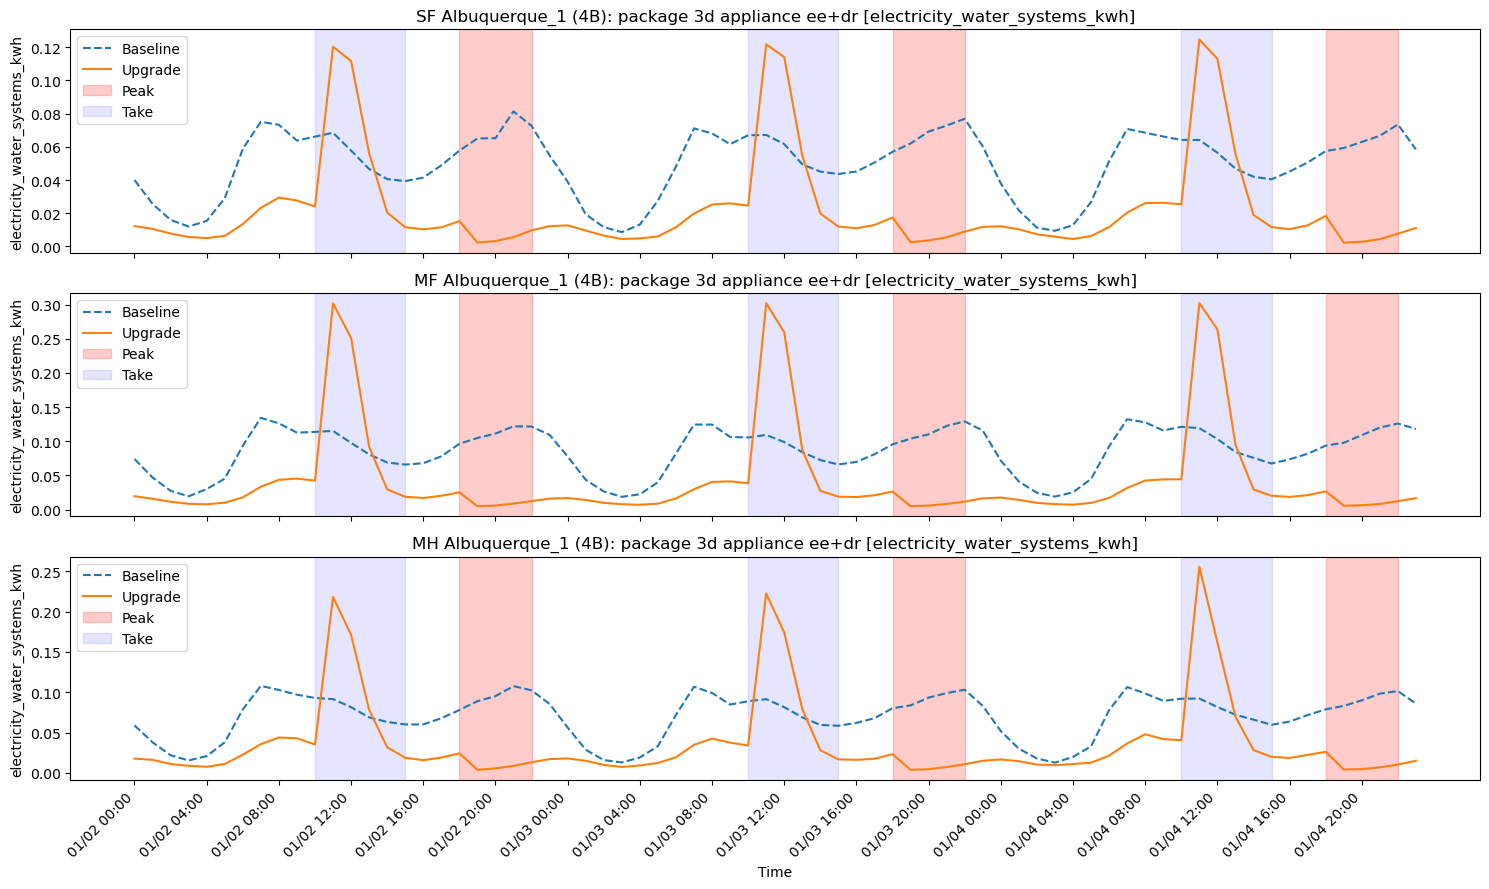

In [44]:
# DENVER - package 3b,summer/winter
btypes=['SF', 'MF', 'MH']
enduse = 'electricity_water_systems_kwh'
city = 'Albuquerque_1'
start_day = 212
# plot_single_upgrade(city, enduse, 5, start_day, period=3*24, btypes=btypes, savefig=False)

start_day = 1
plot_single_upgrade(city, enduse, 16, start_day, period=3*24, btypes=btypes, savefig=False)

C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different l

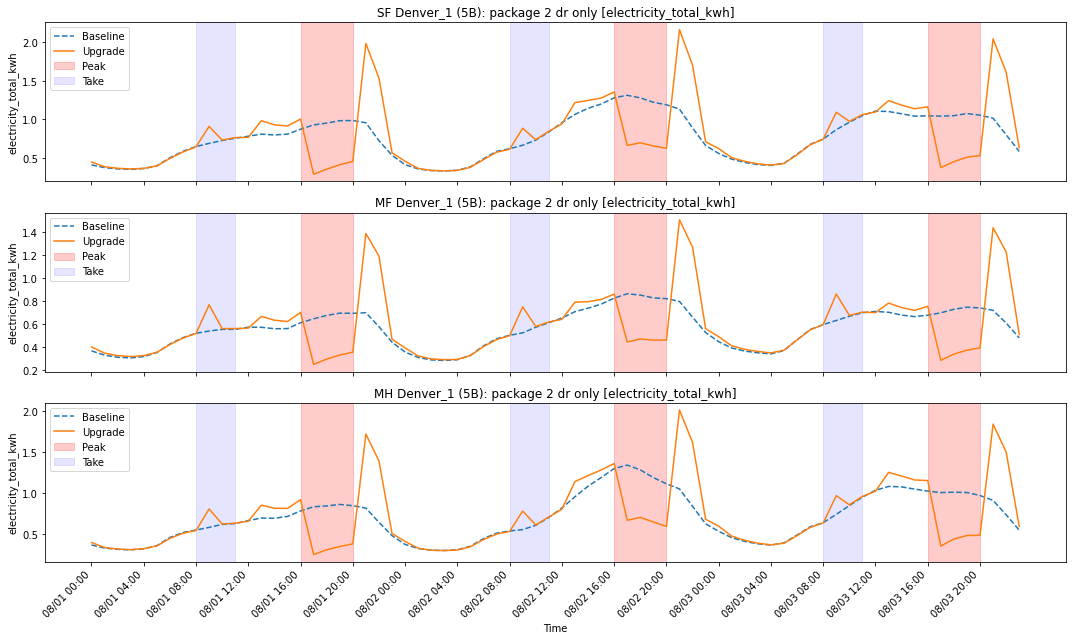

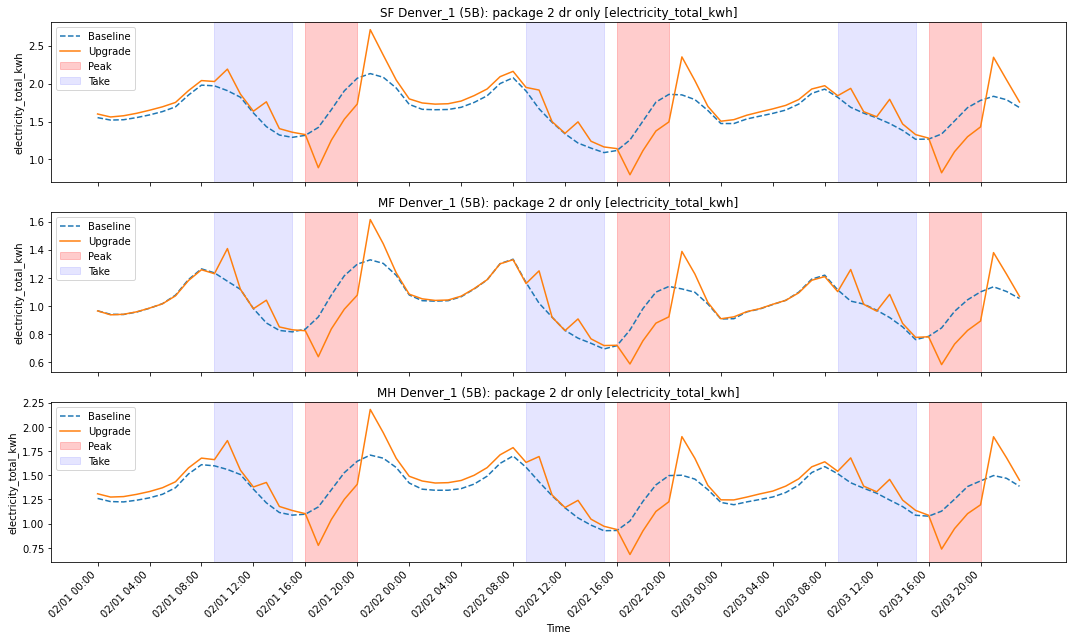

In [316]:
enduse = 'electricity_total_kwh'
city = 'Denver_1'
start = 212
plot_single_upgrade(city, enduse, 12, start, period=3*24, btypes=btypes, savefig=True)

start = 31
plot_single_upgrade(city, enduse, 12, start, period=3*24, btypes=btypes, savefig=True)

C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different l

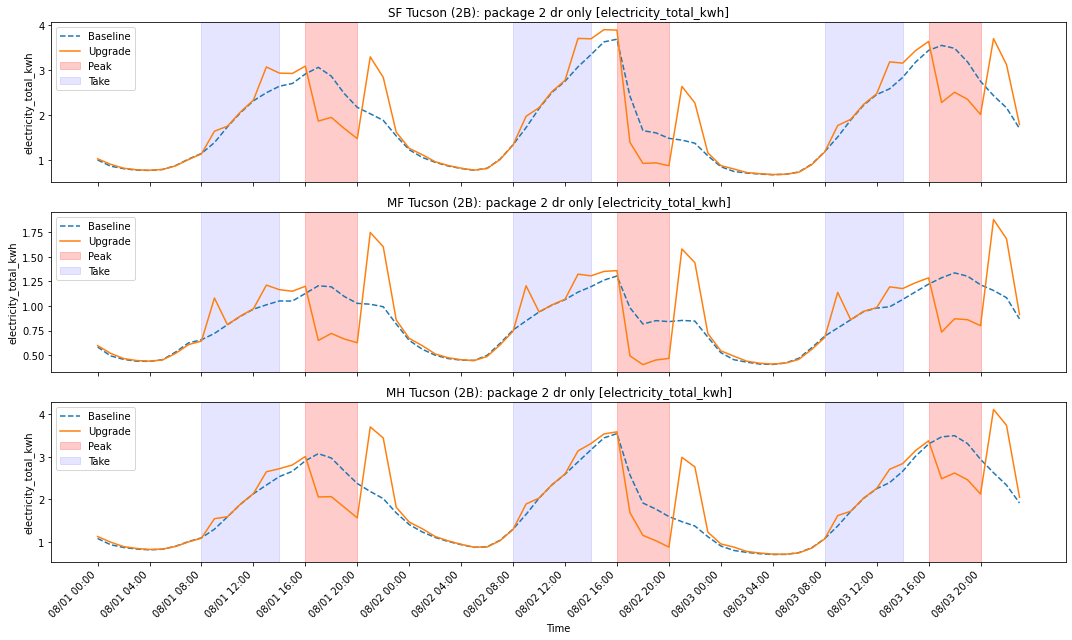

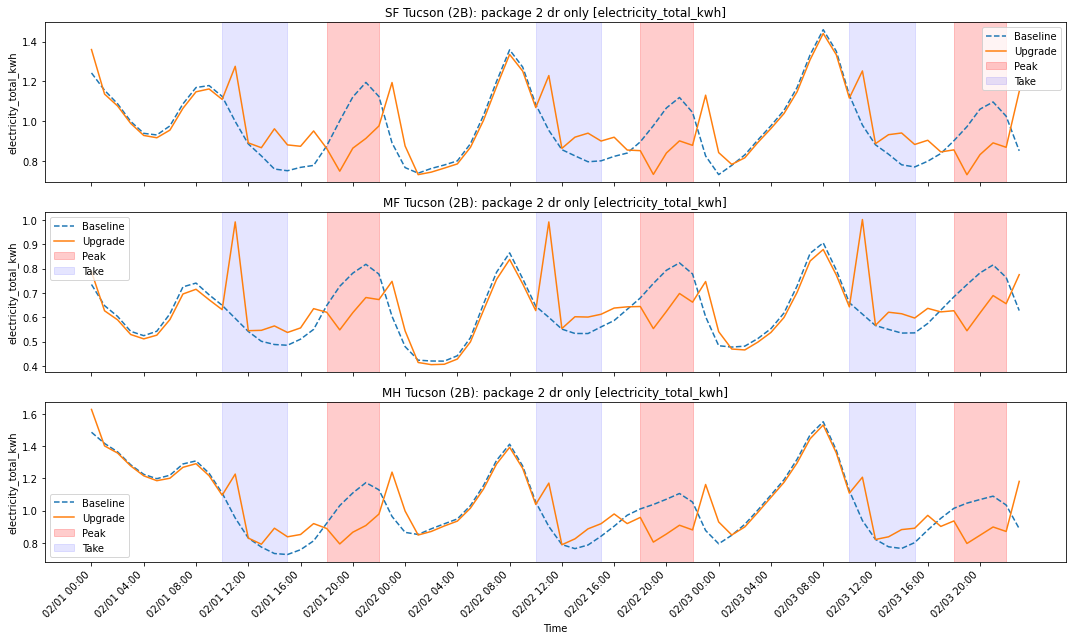

In [317]:
enduse = 'electricity_total_kwh'
city = 'Tucson'
start = 212
plot_single_upgrade(city, enduse, 12, start, period=3*24, btypes=btypes, savefig=True)

start = 31
plot_single_upgrade(city, enduse, 12, start, period=3*24, btypes=btypes, savefig=True)

C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different l

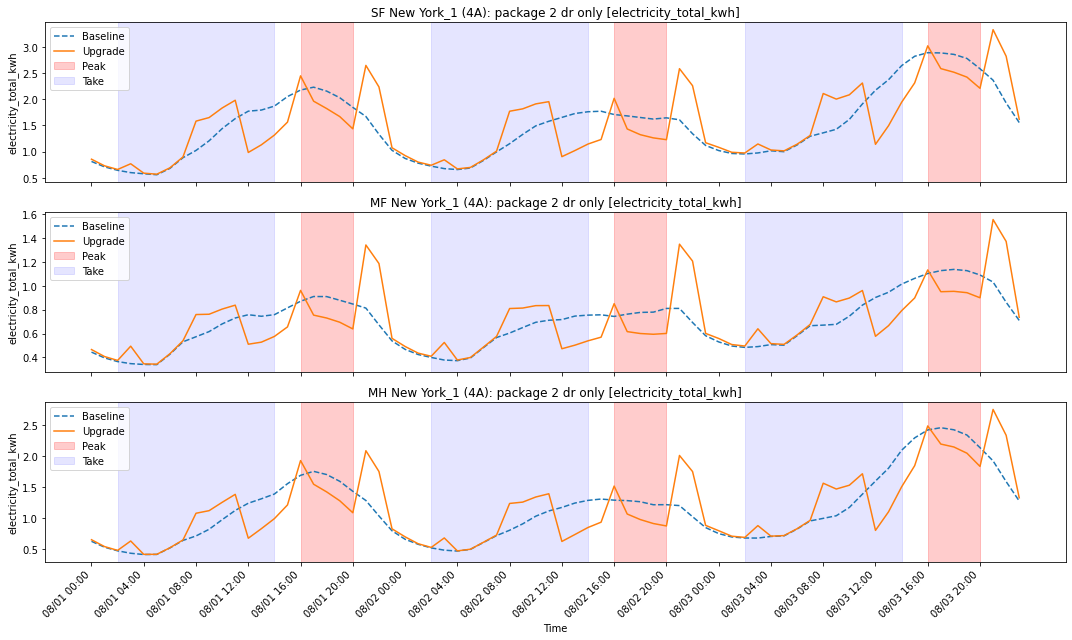

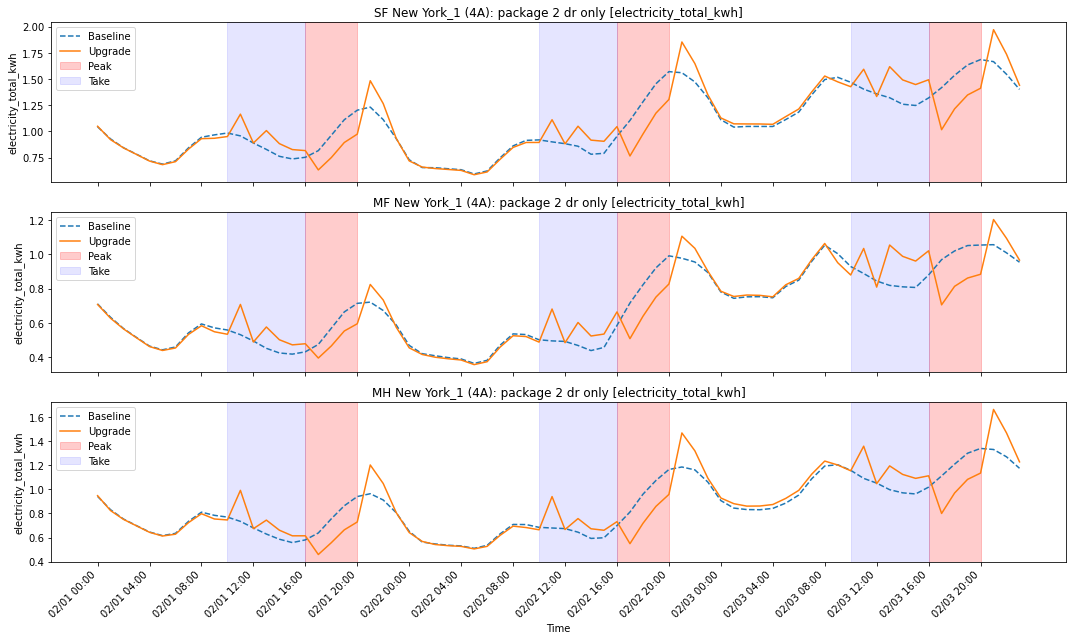

In [318]:
enduse = 'electricity_total_kwh'
city = 'New York_1'
start = 212
plot_single_upgrade(city, enduse, 12, start, period=3*24, btypes=btypes, savefig=True)

start = 31
plot_single_upgrade(city, enduse, 12, start, period=3*24, btypes=btypes, savefig=True)

C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different l

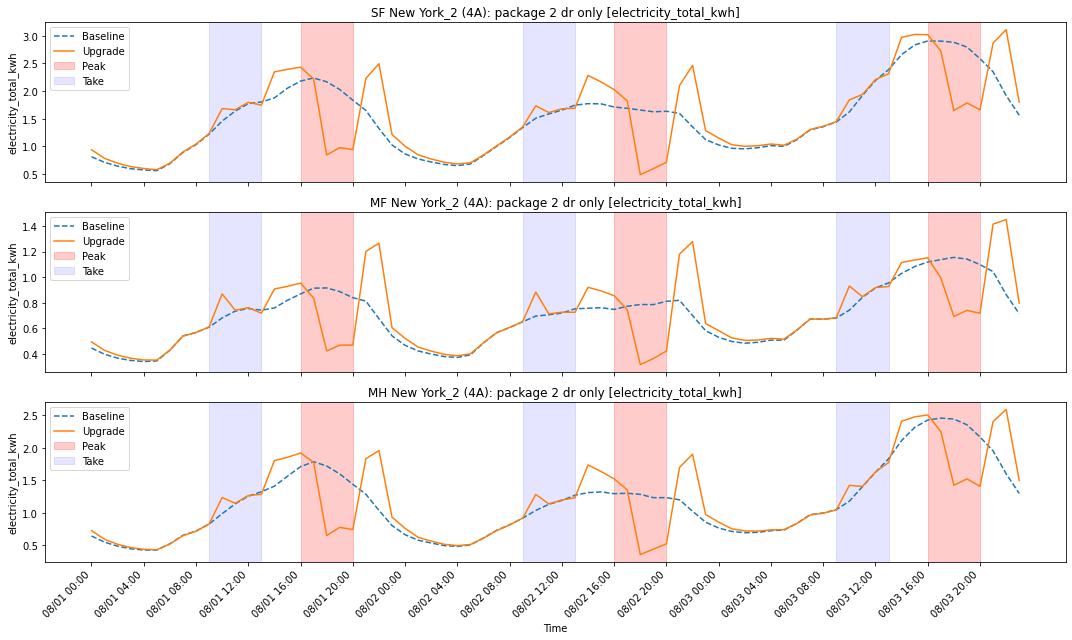

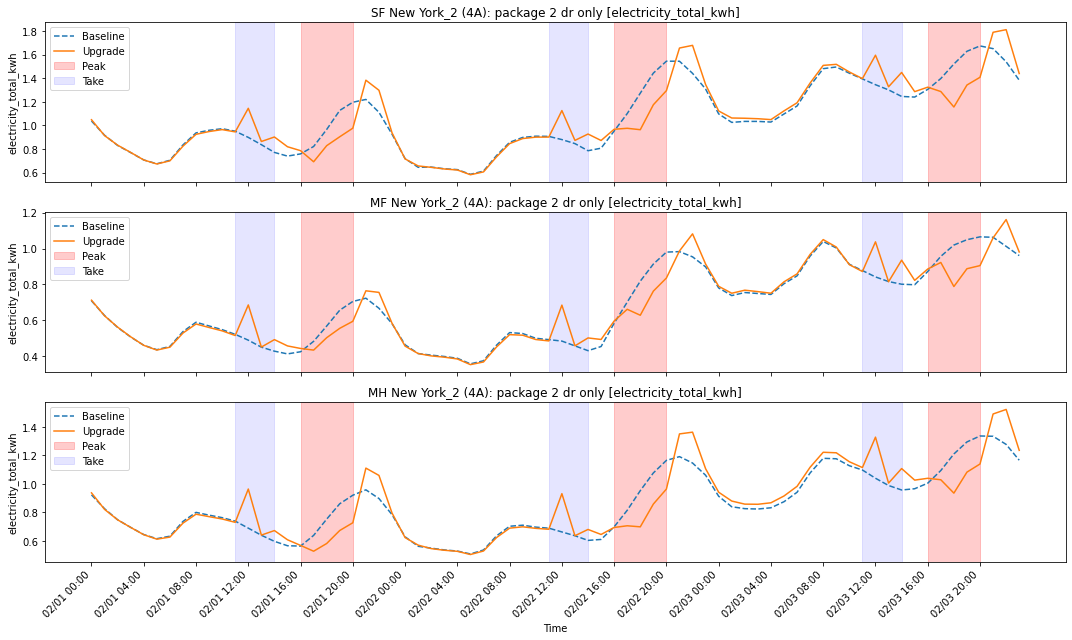

In [319]:
enduse = 'electricity_total_kwh'
city = 'New York_2'
start = 212
plot_single_upgrade(city, enduse, 12, start, period=3*24, btypes=btypes, savefig=True)

start = 31
plot_single_upgrade(city, enduse, 12, start, period=3*24, btypes=btypes, savefig=True)

C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different l

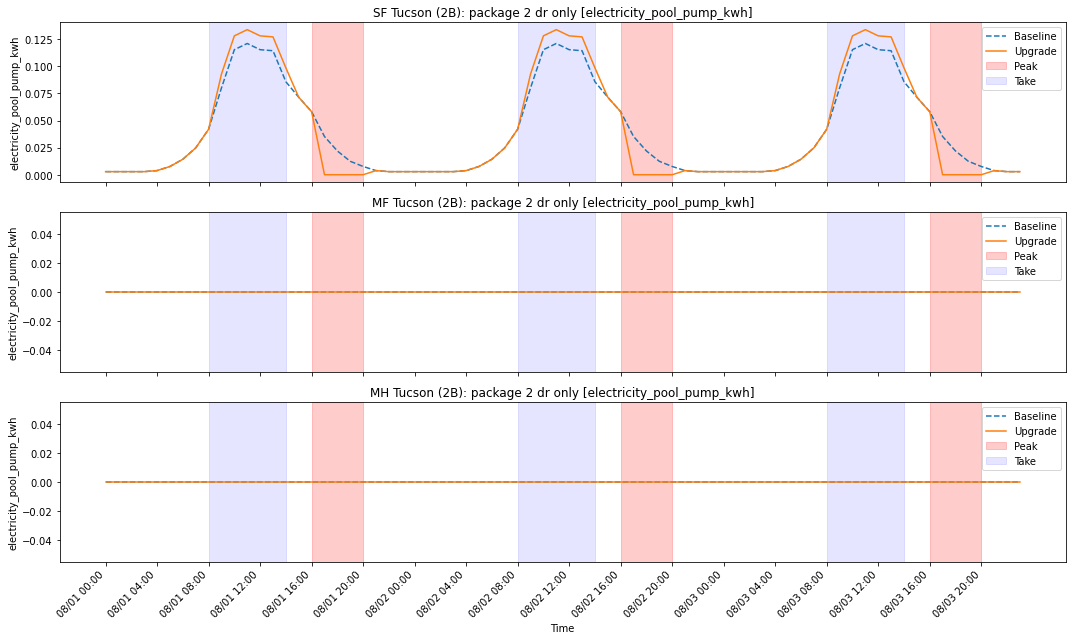

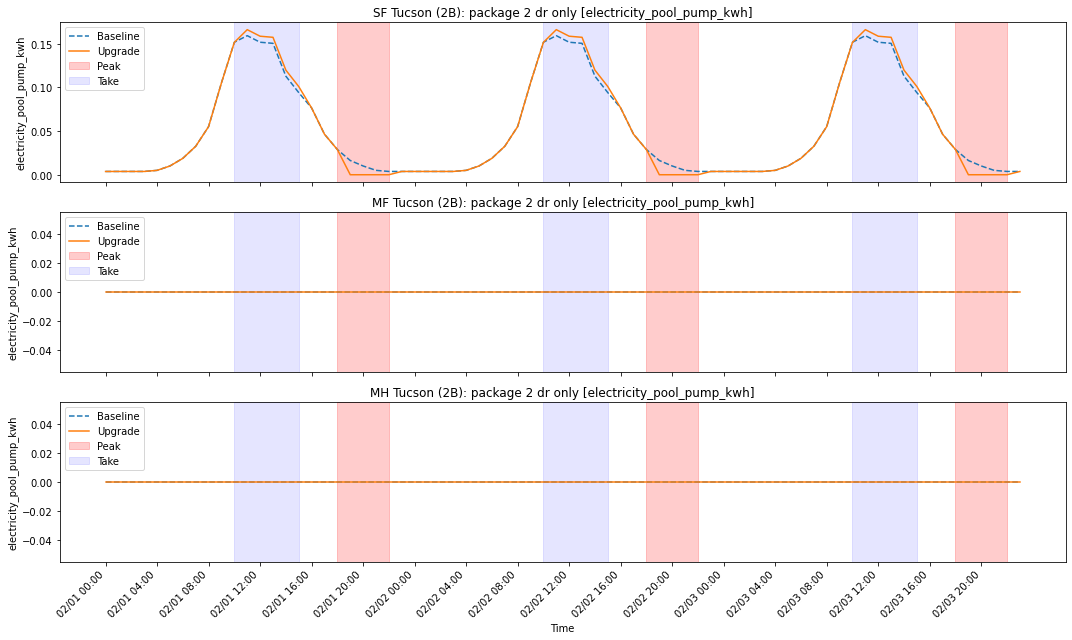

In [331]:
enduse = 'electricity_pool_pump_kwh'
city = 'Tucson'
start = 212
plot_single_upgrade(city, enduse, 12, start, period=3*24, btypes=btypes, savefig=True)

start = 31
plot_single_upgrade(city, enduse, 12, start, period=3*24, btypes=btypes, savefig=True)

C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different l

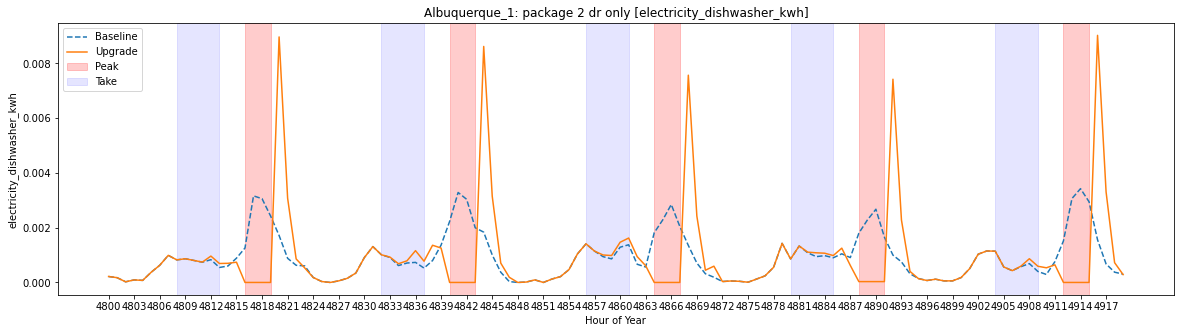

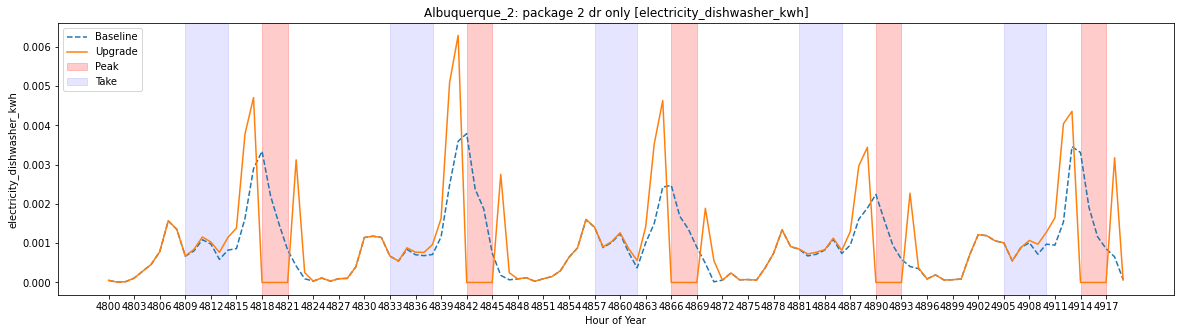

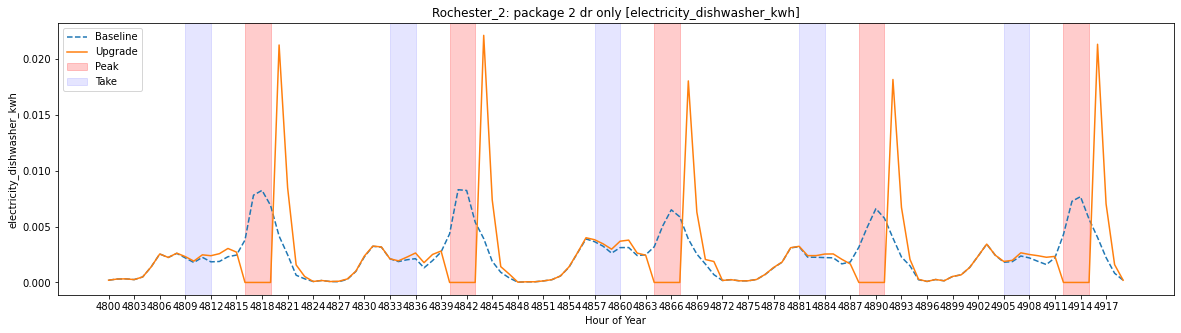

In [25]:
start_day = 200
enduse = 'electricity_dishwasher_kwh'
plot_single_upgrade('Albuquerque_1', enduse, 12, start_day, period=5*24)
plot_single_upgrade('Albuquerque_2', enduse, 12, start_day, period=5*24)
plot_single_upgrade('Rochester_2', enduse, 12, start_day, period=5*24)

# start_day = 0
# enduse = 'electricity_dishwasher_kwh'
# plot_single_upgrade('Albuquerque_1', enduse, 12, start_day, period=5*24)
# plot_single_upgrade('Denver_1', enduse, 12, start_day, period=5*24)


C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different l

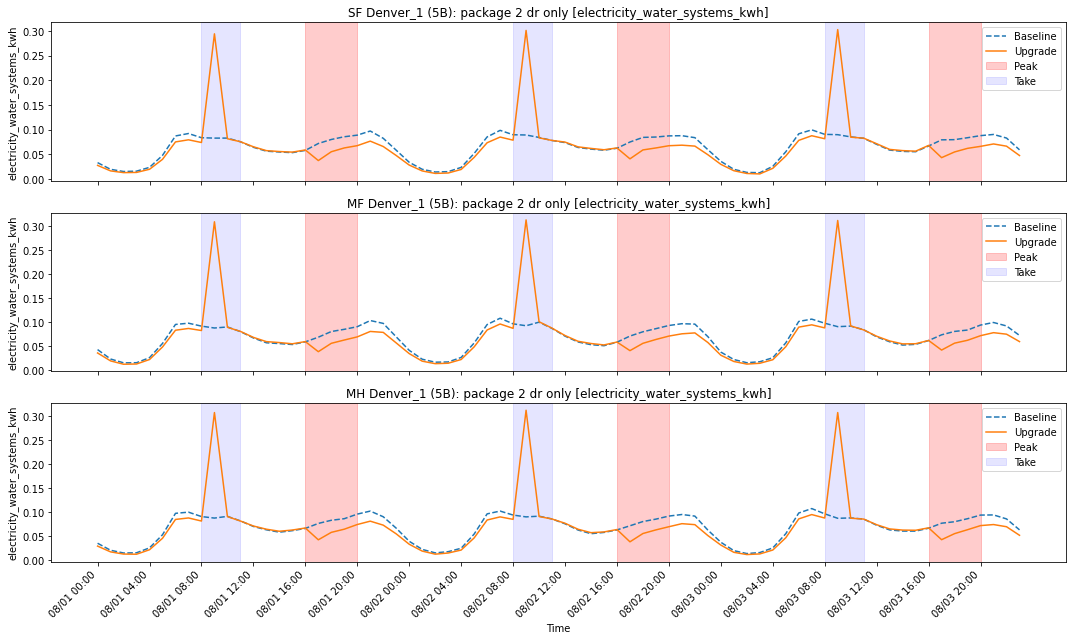

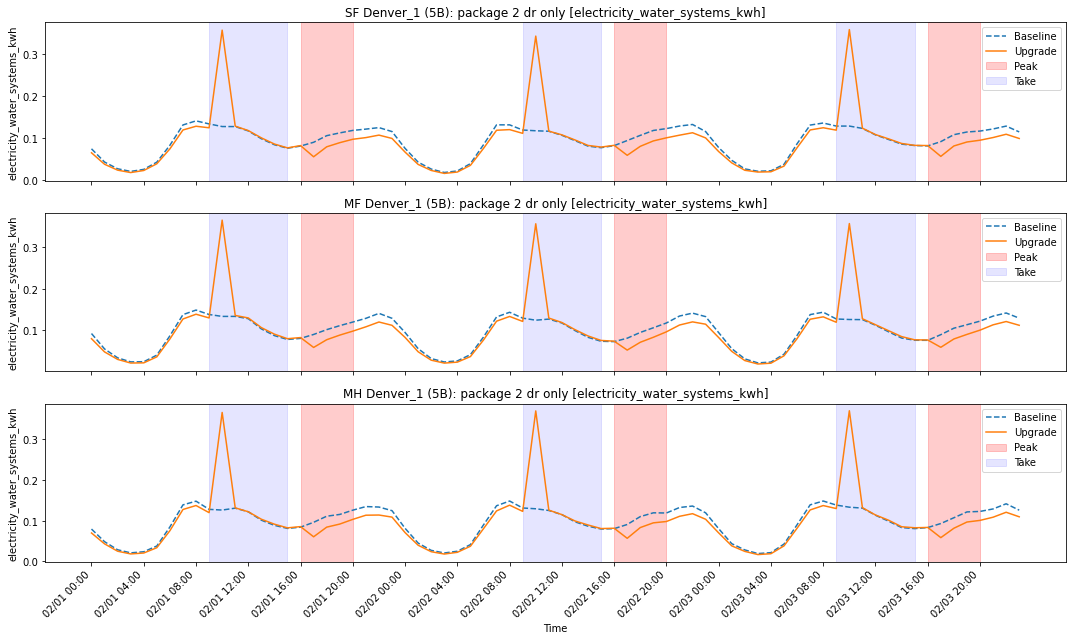

In [332]:
enduse = 'electricity_water_systems_kwh'
start = 0

city = 'Denver_1'
start = 212
plot_single_upgrade(city, enduse, 12, start, period=3*24, btypes=btypes, savefig=False)

start = 31


C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\aspeake\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different l

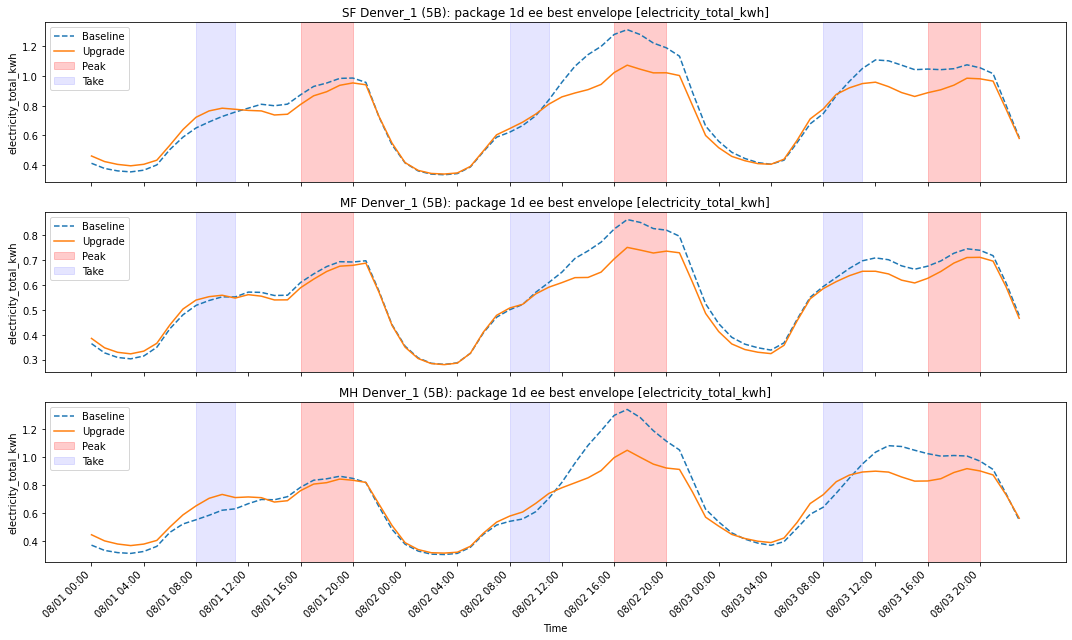

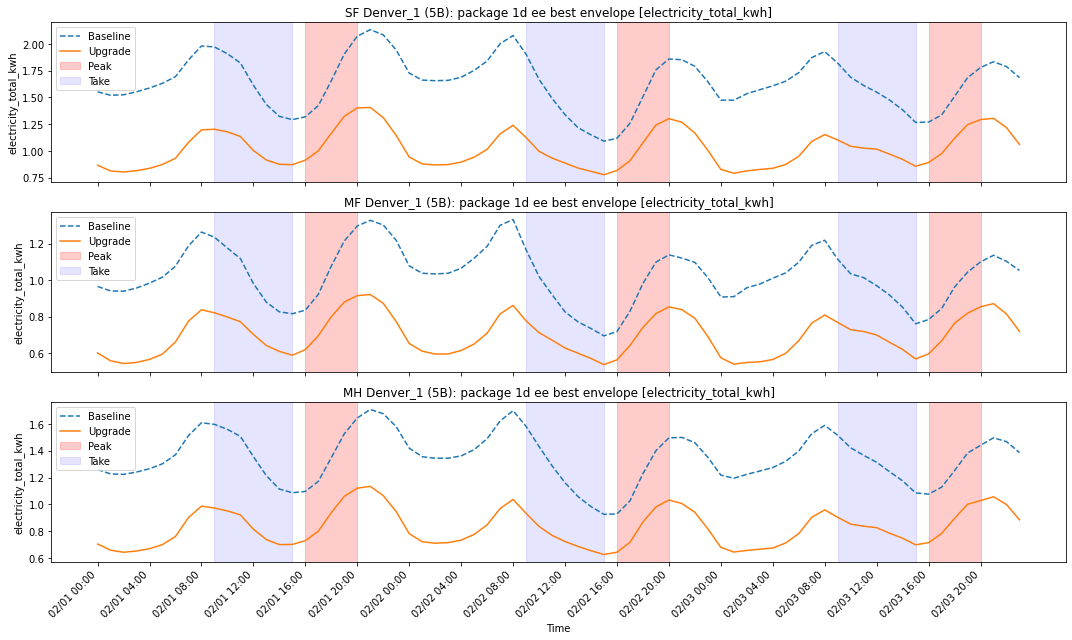

In [337]:
enduse = 'electricity_total_kwh'
city = 'Denver_1'
start = 212
plot_single_upgrade(city, enduse, 4, start, period=3*24, btypes=btypes, savefig=True)

start = 31
plot_single_upgrade(city, enduse, 4, start, period=3*24, btypes=btypes, savefig=True)

## Write Output CSVs

### Functions

In [45]:
# FY22 Runs
def get_FY22_inputs():
    heating = ('heating',["electricity_heating_kwh", "electricity_fans_heating_kwh",
              "electricity_pumps_heating_kwh"])
    cooling = ('cooling',["electricity_cooling_kwh", "electricity_fans_cooling_kwh",
              "electricity_pumps_cooling_kwh"])
    lighting = ('lighting',["electricity_interior_lighting_kwh"])
    refrigerator = ('refrigeration',["electricity_refrigerator_kwh"])
    water_heater = ('water heating',["electricity_water_systems_kwh"])
    clothes_washer = ('clothes washing',["electricity_clothes_washer_kwh"])
    clothes_dryer = ('drying',["electricity_clothes_dryer_kwh"])
    dish_washer = ('dishwasher',["electricity_dishwasher_kwh"])
    pool_pump = ('pool heaters and pumps',["electricity_pool_pump_kwh","electricity_pool_heater_kwh"])
    electronics = ('plug loads',["electricity_plug_loads_kwh"])
    measure_map = {
        'Best CAC': {'upgrades': [1], 'enduses': [cooling]},
        'Best ASHP': {'upgrades': [2], 'enduses': [heating,cooling]},
        'Best thermostat': {'upgrades': [3], 'enduses': [heating,cooling]},
        'Best envelope': {'upgrades': [4], 'enduses': [heating,cooling]},
        'Best lighting': {'upgrades': [5,16], 'enduses': [lighting]},
        'Best refrigerator': {'upgrades': [5,16], 'enduses': [refrigerator]},
        'Best waterheater': {'upgrades': [5], 'enduses': [water_heater]},
        'Best clothes washer': {'upgrades': [5], 'enduses': [clothes_washer]},
        'Best clothes dryer': {'upgrades': [5], 'enduses': [clothes_dryer]},
        'Best dishwasher': {'upgrades': [5], 'enduses': [dish_washer]},
        'Best pool pump': {'upgrades': [5], 'enduses': [pool_pump]},
        'Best electronics': {'upgrades': [5], 'enduses': [electronics]},
        'Best envelope thermostat CAC': {'upgrades': [6], 'enduses': [heating,cooling]},
        'Best envelope thermostat ASHP': {'upgrades': [7], 'enduses': [heating,cooling]},
        'Best envelope thermostat other': {'upgrades': [8], 'enduses': [heating,cooling]},
        'Best envelope opaque' : {'upgrades': [9], 'enduses': [heating,cooling]},
        'Best envelope air sealing' : {'upgrades': [10], 'enduses': [heating,cooling]},
        'Best envelope windows' : {'upgrades': [11], 'enduses': [heating,cooling]},
        'DR waterheater': {'upgrades': [12], 'enduses': [water_heater]},
        'DR clothes washer': {'upgrades': [12], 'enduses': [clothes_washer]},
        'DR clothes dryer': {'upgrades': [12], 'enduses': [clothes_dryer]},
        'DR dishwasher': {'upgrades': [12], 'enduses': [dish_washer]},
        'DR pool pump': {'upgrades': [12], 'enduses': [pool_pump]},
        'DR electronics': {'upgrades': [12], 'enduses': [electronics]},
        'DR thermostat': {'upgrades': [12], 'enduses': [heating,cooling]},
        'Best envelope thermostat CAC DR thermostat': {'upgrades': [13], 'enduses': [heating,cooling]},
        'Best envelope thermostat ASHP DR thermostat': {'upgrades': [14], 'enduses': [heating,cooling]},
        'Best envelope thermostat other DR thermostat': {'upgrades': [15], 'enduses': [heating,cooling]},
        'Best waterheater DR waterheater': {'upgrades': [16], 'enduses': [water_heater]},
        'Best clotheswasher DR clotheswasher': {'upgrades': [16], 'enduses': [clothes_washer]},
        'Best clothesdryer DR clothesdryer': {'upgrades': [16], 'enduses': [clothes_dryer]},
        'Best dishwasher DR dishwasher': {'upgrades': [16], 'enduses': [dish_washer]},
        'Best pool pump DR pool pump': {'upgrades': [16], 'enduses': [pool_pump]},
        'Best electronics DR electronics': {'upgrades': [16], 'enduses': [electronics]},
    }

    upgrade_map = {1: '1a', 2: '1b', 3: '1c', 4: '1d', 5: '1e', 6: '1f', 7: '1g', 8: '1h', 9: '1j', 10: '1k', 11: '1m', 12: '2', 13: '3a', 14: '3b', 15: '3c', 16: '3d'}
    baseline_ts_map = {}
    for btype in ['SF', 'MF', 'MH']:
        baseline_ts_map[btype] = {1: base_ts_cac[btype], 2: base_ts_ashp[btype], 3: base_ts[btype], 4: base_ts[btype], 5: base_ts[btype], 6: base_ts_cac[btype], 7: base_ts_ashp[btype], 8: base_ts_other[btype],
                   9: base_ts[btype], 10: base_ts[btype], 11: base_ts[btype], 12: base_ts[btype], 13: base_ts_cac[btype], 14: base_ts_ashp[btype], 15: base_ts_other[btype], 16: base_ts[btype]}
    
    return(measure_map, upgrade_map, baseline_ts_map)


#### Old Functions

In [ ]:
# RUN 2
def get_run_2_inputs():
    heating = ('heating',["electricity_heating_kwh", "electricity_fans_heating_kwh",
              "electricity_pumps_heating_kwh"])
    cooling = ('cooling',["electricity_cooling_kwh", "electricity_fans_cooling_kwh",
              "electricity_pumps_cooling_kwh"])
    lighting = ('lighting',["electricity_interior_lighting_kwh"])
    refrigerator = ('refrigeration',["electricity_refrigerator_kwh"])
    water_heater = ('water heating',["electricity_water_systems_kwh"])
    clothes_washer = ('clothes washing',["electricity_clothes_washer_kwh"])
    clothes_dryer = ('drying',["electricity_clothes_dryer_kwh"])
    dish_washer = ('dishwasher',["electricity_dishwasher_kwh"])
    pool_pump = ('pool heaters and pumps',["electricity_pool_pump_kwh","electricity_pool_heater_kwh"])
    electronics = ('plug loads',["electricity_plug_loads_kwh"])
    measure_map = {
        'Best CAC': {'upgrades': [1], 'enduses': [cooling]},
        'Best ASHP': {'upgrades': [2], 'enduses': [heating,cooling]},
        'Best thermostat': {'upgrades': [3], 'enduses': [heating,cooling]},
        'Best envelope': {'upgrades': [4], 'enduses': [heating,cooling]},
        'Best lighting': {'upgrades': [5,16], 'enduses': [lighting]},
        'Best refrigerator': {'upgrades': [5,16], 'enduses': [refrigerator]},
        'Best waterheater': {'upgrades': [5], 'enduses': [water_heater]},
        'Best clothes washer': {'upgrades': [5], 'enduses': [clothes_washer]},
        'Best clothes dryer': {'upgrades': [5], 'enduses': [clothes_dryer]},
        'Best dishwasher': {'upgrades': [5], 'enduses': [dish_washer]},
        'Best pool pump': {'upgrades': [5], 'enduses': [pool_pump]},
        'Best electronics': {'upgrades': [5], 'enduses': [electronics]},
        'Best envelope thermostat CAC': {'upgrades': [6], 'enduses': [heating,cooling]},
        'Best envelope thermostat ASHP': {'upgrades': [7], 'enduses': [heating,cooling]},
        'Best envelope thermostat other': {'upgrades': [8], 'enduses': [heating,cooling]},
        'Best envelope opaque' : {'upgrades': [9], 'enduses': [heating,cooling]},
        'Best envelope air sealing' : {'upgrades': [10], 'enduses': [heating,cooling]},
        'Best envelope windows' : {'upgrades': [11], 'enduses': [heating,cooling]},
        'DR waterheater': {'upgrades': [12], 'enduses': [water_heater]},
        'DR clothes washer': {'upgrades': [12], 'enduses': [clothes_washer]},
        'DR clothes dryer': {'upgrades': [12], 'enduses': [clothes_dryer]},
        'DR dishwasher': {'upgrades': [12], 'enduses': [dish_washer]},
        'DR pool pump': {'upgrades': [12], 'enduses': [pool_pump]},
        'DR electronics': {'upgrades': [12], 'enduses': [electronics]},
        'DR thermostat': {'upgrades': [12], 'enduses': [heating,cooling]},
        'Best envelope thermostat CAC DR thermostat': {'upgrades': [13], 'enduses': [heating,cooling]},
        'Best envelope thermostat ASHP DR thermostat': {'upgrades': [14], 'enduses': [heating,cooling]},
        'Best envelope thermostat other DR thermostat': {'upgrades': [15], 'enduses': [heating,cooling]},
        'Best waterheater DR waterheater': {'upgrades': [16], 'enduses': [water_heater]},
        'Best clotheswasher DR clotheswasher': {'upgrades': [16], 'enduses': [clothes_washer]},
        'Best clothesdryer DR clothesdryer': {'upgrades': [16], 'enduses': [clothes_dryer]},
        'Best dishwasher DR dishwasher': {'upgrades': [16], 'enduses': [dish_washer]},
        'Best pool pump DR pool pump': {'upgrades': [16], 'enduses': [pool_pump]},
        'Best electronics DR electronics': {'upgrades': [16], 'enduses': [electronics]},
    }
    upgrade_map = {1: '1a', 2: '1b', 3: '1c', 4: '1d', 5: '1e', 6: '1f', 7: '1g', 8: '1h', 9: '1j', 10: '1k', 11: '1m', 12: '2', 13: '3a', 14: '3b', 15: '3c', 16: '3d'}
    baseline_ts_map = {1: baseline_ts_cac, 2: baseline_ts_ashp, 3: baseline_ts, 4: baseline_ts, 5: baseline_ts, 6: baseline_ts_cac, 7: baseline_ts_ashp, 8: baseline_ts_other,
                       9: baseline_ts, 10: baseline_ts, 11: baseline_ts, 12: baseline_ts, 13: baseline_ts_cac, 14: baseline_ts_ashp, 15: baseline_ts_other, 16: baseline_ts}
#     baseline_ts_map = None
    return(measure_map, upgrade_map, baseline_ts_map)

# BRATTLE MEASURES
def get_brattle_inputs():
    heating = ('heating',["electricity_heating_kwh", "electricity_fans_heating_kwh",
              "electricity_pumps_heating_kwh"])
    cooling = ('cooling',["electricity_cooling_kwh", "electricity_fans_cooling_kwh",
              "electricity_pumps_cooling_kwh"])
    lighting = ('lighting',["electricity_interior_lighting_kwh"])
    refrigerator = ('refrigeration',["electricity_refrigerator_kwh"])
    water_heater = ('water heating',["electricity_water_systems_kwh"])
    clothes_washer = ('clothes washing',["electricity_clothes_washer_kwh"])
    clothes_dryer = ('drying',["electricity_clothes_dryer_kwh"])
    dish_washer = ('dishwasher',["electricity_dishwasher_kwh"])
    pool_pump = ('pool heaters and pumps',["electricity_pool_pump_kwh","electricity_pool_heater_kwh"])
    electronics = ('plug loads',["electricity_plug_loads_kwh"])
    measure_map = {
        'upgrade_1_ICT_precond': {'upgrades': [1], 'enduses': [heating,cooling]},
        'upgrade_2_CAC_ICT_precond': {'upgrades': [2], 'enduses': [heating,cooling]},
        'upgrade_3_ASHP_ICT_precond': {'upgrades': [3], 'enduses': [heating,cooling]},
        'upgrade_4_CAC_ICT': {'upgrades': [4], 'enduses': [heating,cooling]},
        'upgrade_5_ASHP_ICT': {'upgrades': [5], 'enduses': [heating,cooling]},    
    }
    upgrade_map = {1: '1', 2: '2', 3: '3', 4: '4', 5: '5'}
    baseline_ts_map = { 1: base_ts, 2: base_ts, 3: base_ts, 4: base_ts, 5: base_ts,}
    return(measure_map, upgrade_map, baseline_ts_map)


# SENSITIVITY ANALYSIS INPUTS
def get_sens_analysis_inputs():
    heating = ('heating',["electricity_heating_kwh", "electricity_fans_heating_kwh",
              "electricity_pumps_heating_kwh"])
    cooling = ('cooling',["electricity_cooling_kwh", "electricity_fans_cooling_kwh",
              "electricity_pumps_cooling_kwh"])
    measure_map = {'upgrade_2_DR': {'upgrades': [1], 'enduses': [heating,cooling]}}
    upgrade_map = {1: '2'}
    baseline_ts_map = {1: base_ts}   
    return(measure_map, upgrade_map, baseline_ts_map)

def get_DR_package_inputs():
    heating = ('heating',["electricity_heating_kwh", "electricity_fans_heating_kwh",
              "electricity_pumps_heating_kwh"])
    cooling = ('cooling',["electricity_cooling_kwh", "electricity_fans_cooling_kwh",
              "electricity_pumps_cooling_kwh"])
    lighting = ('lighting',["electricity_interior_lighting_kwh"])
    refrigerator = ('refrigeration',["electricity_refrigerator_kwh"])
    water_heater = ('water heating',["electricity_water_systems_kwh"])
    clothes_washer = ('clothes washing',["electricity_clothes_washer_kwh"])
    clothes_dryer = ('drying',["electricity_clothes_dryer_kwh"])
    dish_washer = ('dishwasher',["electricity_dishwasher_kwh"])
    pool_pump = ('pool heaters and pumps',["electricity_pool_pump_kwh","electricity_pool_heater_kwh"])
    electronics = ('plug loads',["electricity_plug_loads_kwh"])
    measure_map = {
        'DR waterheater': {'upgrades': [12], 'enduses': [water_heater]},
        'DR clothes washer': {'upgrades': [12], 'enduses': [clothes_washer]},
        'DR clothes dryer': {'upgrades': [12], 'enduses': [clothes_dryer]},
        'DR dishwasher': {'upgrades': [12], 'enduses': [dish_washer]},
        'DR pool pump': {'upgrades': [12], 'enduses': [pool_pump]},
        'DR electronics': {'upgrades': [12], 'enduses': [electronics]},
        'DR thermostat': {'upgrades': [12], 'enduses': [heating,cooling]}}
    upgrade_map = {12: '2'}
    baseline_ts_map = None 
    return(measure_map, upgrade_map, baseline_ts_map)

### Write Csvs

In [47]:
run_only = [16]

measure_map, upgrade_map, baseline_ts_map = get_FY22_inputs()
location_map = {
    'Seattle_1':'4C', 'Seattle_2':'4C', 'Atlanta_1': '3A', 'Atlanta_2': '3A', 'Denver_1': '5B', 'Denver_2': '5B', 'Tucson':'2B',
    'New York_1':'4A', 'New York_2':'4A', 'San Diego': '3C', 'Tampa_1': '2A', 'Tampa_2': '2A', 
    'Albuquerque_1':'4B', 'Albuquerque_2':'4B', 'Buffalo_1':'5A', 'Buffalo_2':'5A', 'Midland_1': '3B', 'Midland_2': '3B', 'Rochester_1':'6A',
    'Rochester_2':'6A', 'International Falls_1': '7', 'International Falls_2': '7', 'Great Falls_1':'6B', 'Great Falls_2':'6B', 'Port Angeles':'5C'
}

# up_dict = {}
upgrade_list = upgrades_ts['SF']['upgrade'].unique()
# for up in sorted(upgrade_list):
#     up_dict[up] = upgrades_ts[upgrades_ts['upgrade'] == up]
dr_locations = base_ts['SF']['city'].unique()
l1,l2 = None,None
saving_shape_dict = {}
out_dir = './output_csvs/v2.5.0/all_test/'
def generate_csvs():
    for measure, config in measure_map.items():
        for upgrade in config['upgrades']:
            if not upgrade in upgrade_list:
                continue
            measure = measure.replace(' ', '_')
            upgrade_name = upgrade_map[upgrade]
            if run_only and upgrade not in run_only:
                print(f'Skipping {upgrade_name}')
                continue
                
            file_name = f'P{upgrade_name}_{measure}'            
            print(f'Writing {file_name}.csv, (upgrade {upgrade})')
            csv_dfs = []
            csv_baseline = []
            csv_upgrades = []
            annual_change = pd.DataFrame()
            savings_df_array = []
            for location in dr_locations:
                for btype in btypes:
                    ts_data_base = baseline_ts_map[btype][upgrade] 
                    ts_data_upgrade = upgrades_ts[btype][upgrades_ts[btype]['upgrade']==upgrade]
                    
                    def get_clean_pq(pq):
                        new_pq = pd.DataFrame()
                        for enduse_group in config['enduses']:
                            new_pq[enduse_group[0]] = pq[enduse_group[1]].sum(axis=1)
                        clean_pq = new_pq.reset_index().drop(columns=['index'])
                        return clean_pq
                    
                    current = get_clean_pq(ts_data_upgrade.query('city==@location'))
                    baseline = get_clean_pq(ts_data_base.query('city==@location'))
                    if len(location.split('_')) > 1:
                        load_version = int(location.split('_')[1])
                    else:
                        load_version = 1
                    for col in baseline.columns:   
                        savings_df = pd.DataFrame()
                        savings_df['Hour of Year'] = list(range(1,8761))
                        savings_df['Climate Zone'] = location_map[location]
                        savings_df['Net Load Version'] = load_version
                        savings_df['Building Type'] = btype
                        savings_df['End Use'] = col
                        savings_df['Baseline Load'] = baseline[col]
                        savings_df['Measure Load'] = current[col]
                        savings_df['Relative Savings'] = (current[col]-baseline[col])/(baseline[col].sum())
                        savings_df_array.append(savings_df)
                    annual_change[location] = (current.sum()-baseline.sum())/baseline.sum()
            
            full_savings_csvs = pd.concat(savings_df_array)
            saving_shape_dict[measure] = full_savings_csvs
            annual_change.to_csv(out_dir+f'/annual_changes/{file_name}_annual_change.csv')
            full_savings_csvs.to_csv(out_dir+f'/savings_shape/{file_name}.csv',index=False)

generate_csvs()

Skipping 1a
Skipping 1b
Skipping 1c
Skipping 1d
Skipping 1e
Writing P3d_Best_lighting.csv, (upgrade 16)
Skipping 1e
Writing P3d_Best_refrigerator.csv, (upgrade 16)
Skipping 1e
Skipping 1e
Skipping 1e
Skipping 1e
Skipping 1e
Skipping 1e
Skipping 1f
Skipping 1g
Skipping 1h
Skipping 1j
Skipping 1k
Skipping 1m
Skipping 2
Skipping 2
Skipping 2
Skipping 2
Skipping 2
Skipping 2
Skipping 2
Skipping 3a
Skipping 3b
Skipping 3c
Writing P3d_Best_waterheater_DR_waterheater.csv, (upgrade 16)
Writing P3d_Best_clotheswasher_DR_clotheswasher.csv, (upgrade 16)
Writing P3d_Best_clothesdryer_DR_clothesdryer.csv, (upgrade 16)
Writing P3d_Best_dishwasher_DR_dishwasher.csv, (upgrade 16)
Writing P3d_Best_pool_pump_DR_pool_pump.csv, (upgrade 16)
Writing P3d_Best_electronics_DR_electronics.csv, (upgrade 16)


#############################################################################\
Below is old code that has not been looked at in a while

## Compare Two Runs - Annual

In [6]:
run1_dir = '../Resstock_results/Original_runs/Run_2'
# run1 = pd.read_csv(os.path.join(run1_dir, 'baseline_electric_enduses_08.2020.csv'))
run1 = pd.read_parquet(os.path.join(run1_dir, 'results_up00.parquet'))

run2 = results['up00']
run2['build_existing_model.city'] = run2['build_existing_model.location_city']


In [7]:
import networkx as nx
def repel_labels(ax, x, y, labels, k=0.01):
    # https://stackoverflow.com/questions/14938541/how-to-improve-the-label-placement-for-matplotlib-scatter-chart-code-algorithm
    G = nx.DiGraph()
    data_nodes = []
    init_pos = {}
    for xi, yi, label in zip(x, y, labels):
        data_str = 'data_{0}'.format(label)
        G.add_node(data_str)
        G.add_node(label)
        G.add_edge(label, data_str)
        data_nodes.append(data_str)
        init_pos[data_str] = (xi, yi)
        init_pos[label] = (xi, yi)

    pos = nx.spring_layout(G, pos=init_pos, fixed=data_nodes, k=k)

    # undo spring_layout's rescaling
    pos_after = np.vstack([pos[d] for d in data_nodes])
    pos_before = np.vstack([init_pos[d] for d in data_nodes])
    scale, shift_x = np.polyfit(pos_after[:,0], pos_before[:,0], 1)
    scale, shift_y = np.polyfit(pos_after[:,1], pos_before[:,1], 1)
    shift = np.array([shift_x, shift_y])
    for key, val in pos.items():
        pos[key] = (val*scale) + shift

    for label, data_str in G.edges():
        ax.annotate(label,
                    xy=pos[data_str], xycoords='data',
                    xytext=pos[label], textcoords='data')
    # expand limits
    all_pos = np.vstack(pos.values())
    x_span, y_span = np.ptp(all_pos, axis=0)
    mins = np.min(all_pos-x_span*0.15, 0)
    maxs = np.max(all_pos+y_span*0.15, 0)
    ax.set_xlim([mins[0], maxs[0]])
    ax.set_ylim([mins[1], maxs[1]])
    
    
def scatter_plot(x_df, y_df, enduse, param_filters=None, save_path=None, threshold=0, group_cities=True):
    x_df = x_df[x_df[enduse] >= threshold]
    y_df = y_df[y_df[enduse] >= threshold]
    
    for param_filter in param_filters:
        x_df = x_df[x_df[param_filter[0]].isin(param_filter[1])]
        y_df = y_df[y_df[param_filter[0]].isin(param_filter[1])]
    
    if enduse == 'simulation_output_report.electricity_heating_kwh':
        y_df[enduse + '_perft2'] = (y_df[enduse]+y_df['simulation_output_report.electricity_heating_supplemental_kwh'])/y_df['simulation_output_report.floor_area_conditioned_ft_2']  
    else:
        y_df[enduse + '_perft2'] = (y_df[enduse])/y_df['simulation_output_report.floor_area_conditioned_ft_2']  
        
    x_df[enduse + '_perft2'] = x_df[enduse]/x_df['simulation_output_report.floor_area_conditioned_ft_2']  
    
    x = x_df.groupby('build_existing_model.city').mean()[enduse + '_perft2'].sort_index()
    y = y_df.groupby('build_existing_model.city').mean()[enduse + '_perft2'].sort_index()
    
#     x = x_df.groupby('build_existing_model.city').mean()[enduse].sort_index()
#     y = y_df.groupby('build_existing_model.city').mean()[enduse].sort_index()
    
    plt.figure(figsize=(8,6))
    plt.scatter(x,y)
    ax=plt.gca()
    plt.plot([0, 1], [0, 1], 'k-', transform=ax.transAxes, label='0% Difference', alpha=.5)
    plt.plot([0, .9], [0, 1], 'k--', transform=ax.transAxes, label='+/- 10% Difference', alpha=.5)
    plt.plot([0, 1.1], [0, 1], 'k--', transform=ax.transAxes, alpha=.5)
    
    max_pt = max(max(x), max(y))    
    text = '10k datapoints per city'
        
    plt.text(.7, .05, text, transform=ax.transAxes, bbox=dict(edgecolor='black', facecolor='none', alpha=0.5))
    
    
    fnt = 14
    plt.ylabel(f'Run 2 {enduse.split("_")[-1]}/ft2', fontsize=fnt)
    plt.xlabel(f'Run 1 {enduse.split("_")[-1]}/ft2', fontsize=fnt)
    plt.title(f'{enduse.split(".")[1]}', fontsize=fnt)
    plt.legend()
    
    labels=[]
    for idx in x.index:
        if group_cities:
            if '_1' in idx:
                string = idx.split('_')[0]
            elif '_2' in idx:
                string = ''
            else:
                string = idx
        else:
            string = idx
    
        labels.append(string)
#         plt.text(x=x.loc[idx]+max_pt*.015, y=y.loc[idx]-max_pt/50, s=string)
        
    ax = plt.gca()
    repel_labels(ax, x, y, labels, k=max_pt/53)
    plt.xlim(0, max_pt*1.05)
    plt.ylim(0, max_pt*1.05)

    save_name = 'scatter_compare_' + enduse.split('.')[1]
    if save_path:
        plt.savefig(os.path.join(save_path, save_name), dpi=400, bbox_inches='tight')
        print(save_name)

In [8]:
def plot_histogram(dfs, enduse, labels, param_filters=[], threshold=None, save_path=None, bins=None, city=None):   
    if not bins:
        bins = 50
    if not threshold:
        threshold = 0
        
    plt.figure(figsize=(8,6))
    
    x_plot = []
    
    for df, label in zip(dfs, labels):
        if threshold > 0:
            df = df[df[enduse] >= threshold]
        for param_filter in param_filters:
            df = df[df[param_filter[0]].isin(param_filter[1])]
        if city:
            df = df[df['build_existing_model.city']==city]
            
        x = df[enduse]/df['simulation_output_report.floor_area_conditioned_ft_2']   
        x_plot.append(x)
        print(len(x))
        
    plt.hist(x_plot, bins=bins, alpha=.5, label=labels);
    fnt=14
    plt.ylabel('Count', fontsize=fnt)
    
    x_text = enduse.split(".")[1] + '/ft2'
    if threshold > 0:
        x_text += f'(>{threshold} kwh cutoff)'
    
    plt.xlabel(x_text, fontsize=fnt)
    if city:
        plt.title(city, fontsize=fnt)
    else:
        plt.title('All Locations', fontsize=fnt)
#     plt.axvline(x.median(), color='k', linestyle='dashed', linewidth=1, label='Median')
#     plt.axvline(0, color='k', linestyle='solid', linewidth=1, label='0% Error')
    plt.legend()
    
    save_name = 'histogram_compare_' + enduse.split('.')[1]
    if city:
        save_name += '_' + city
    if save_path:
        plt.savefig(os.path.join(save_path, save_name), dpi=400, bbox_inches='tight')
        print(save_name)

In [9]:
def get_input_counts(dfs, col_headers, parameters, city='None', option_map=None, param_filters=[]):
    index = set()
    for i, df in enumerate(dfs):
        if len(parameters)>1:
            param = parameters[i]
            df[parameters[0]] = df[param]
        else:
            param = parameters[0]
        for idx in df[param].unique():
            if option_map and i==1:
                if idx in option_map.keys():
                    idx = option_map[idx]
            index.add(idx)
            
    parameter = parameters[0]
    for i, df in enumerate(dfs):
        if city:
            df = df[df['build_existing_model.city'] == city]  
        for param_filter in param_filters:
            df = df[df[param_filter[0]].isin(param_filter[1])]
        if isinstance(df[parameter].iloc[0],numbers.Number):
            print(f'{i+1} Average: {df[parameter].mean()}')    
        
    
    index = {x for x in index if pd.notna(x)}
    new_df = pd.DataFrame(columns=col_headers, index=index)
    for df, col in zip(dfs, col_headers):
        if city:
            df = df[df['build_existing_model.city'] == city]  
        for param_filter in param_filters:
            df = df[df[param_filter[0]].isin(param_filter[1])]
            
        df[parameter] = df[parameter].replace(option_map)
        new_df[col] = pd.to_numeric(df[parameter].value_counts(), downcast='integer')
        new_df[col] = round(new_df[col]/new_df[col].sum(), 3)
        
    return(new_df.dropna(how='all'))

### Electric Heating

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


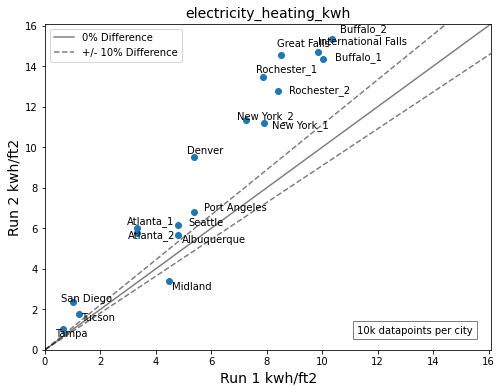

In [10]:
save_path = '../Resstock_results/FY22_runs/figures'
save_path = None
enduse = 'simulation_output_report.electricity_heating_kwh'
param_filter = [('build_existing_model.heating_fuel', ['Electricity'])]

scatter_plot(run1, run2, enduse, param_filters=param_filter, save_path=save_path, threshold=25, group_cities=False)

1050
1011


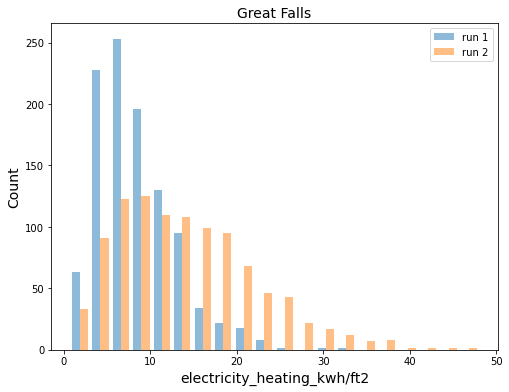

In [337]:
dfs = [run1, run2]
city = 'Great Falls'
enduse = 'simulation_output_report.electricity_heating_kwh'
param_filter = [('build_existing_model.heating_fuel', ['Electricity'])]

plot_histogram(dfs, enduse, ['run 1', 'run 2'], param_filters=param_filter, threshold=0, bins=20, city=city, save_path=save_path)

3426
3516


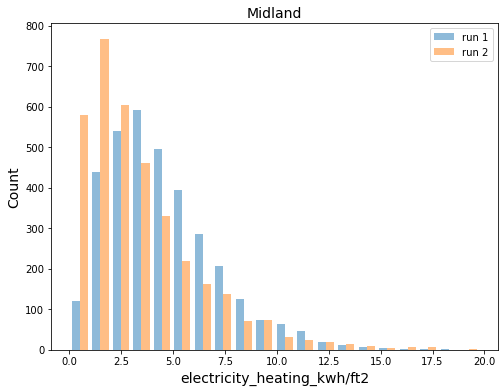

In [338]:
dfs = [run1, run2]
city = 'Midland'
enduse = 'simulation_output_report.electricity_heating_kwh'
param_filter = [('build_existing_model.heating_fuel', ['Electricity'])]

plot_histogram(dfs, enduse, ['run 1', 'run 2'], param_filters=param_filter, threshold=0, bins=20, city=city, save_path=save_path)

- Great Falls: Run 1 has 30% ASHP vs 9% for Run 2
- Denver: Run 2 has an increase in ASHPs (0% -> 22%), but Run 2 has higher heating setpoints; Run 2 has a lot more electric heating; Run 2 has a lot of uninsulated wood homes
- Buffalo: Run 1 has 24% ASHP vs 15% for Run 2
- International Falls: Run 1 has 27% ASHP vs 11% for Run 2
- Rochester: Run 1 has 30% ASHP vs 10% for Run 2
- Atlanta: ASHP saturation is the same; Run 2 has a little higher setpoints, but Run 1 has a lot more electric heating

Decrease:
- Midlant Run 1 has 8% ASHP vs 19% ASHP for Run 2; Run 1 has higher heating setpoints

In [339]:
# Change in Heating Setpoint
city = 'International Falls'
# city = None
params = ['build_existing_model.heating_setpoint']
params = ['build_existing_model.infiltration']
params = ['build_existing_model.insulation_wall']
params = ['build_existing_model.vintage']
params = ['build_existing_model.heating_fuel']


# params = ['build_existing_model.hvac_system_heating_electricity', 'build_existing_model.hvac_heating_efficiency']
# params = ['build_existing_model.hvac_system_heat_pump', 'build_existing_model.hvac_heating_efficiency']
# params = ['simulation_output_report.floor_area_conditioned_ft_2']

# param_filter = [('build_existing_model.heating_fuel', ['Electricity'])]

print(city)
# df=get_input_counts([run1, run2], ['run 1', 'run 2'], params, city, param_filters=param_filter).sort_index()
df=get_input_counts([run1, run2], ['run 1', 'run 2'], params, city).sort_index()

df

International Falls


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,run 1,run 2
Electricity,0.113,0.163
Fuel Oil,0.042,0.118
Natural Gas,0.608,0.327
None,NaN,0.009
Other Fuel,0.025,0.120
Propane,0.212,0.263


In [340]:
df = run2
df = df[df['build_existing_model.heating_fuel']=='Electricity']
df[df['build_existing_model.city']=='Denver']['build_existing_model.vintage'].value_counts().sum()

1662

In [ ]:
# Change in Heating Fuel
city = 'Great Falls'
params = ['build_existing_model.heating_fuel']
param_filter = [('build_existing_model.heating_fuel', ['Electricity'])]

print(city)
get_input_counts([run1, run2], ['run 1', 'run 2'], params, city, param_filters=[])

Large change in average electric heating energy for Port Angeles is likely due to change in heating fuel distribution:

https://github.com/NREL/resstock/pull/474

https://user-images.githubusercontent.com/37630588/89687846-27b85880-d8be-11ea-8f85-86cc6410b28b.png

### Cooling

In [ ]:
enduse = 'simulation_output_report.electricity_cooling_kwh'
param_filter = [('build_existing_model.hvac_system_cooling_type', ['Central', 'Room'])]

option_map = {'Central AC': 'Central', 'Room AC': 'Room', 'Heat Pump': 'Central'}
run2['build_existing_model.hvac_system_cooling_type'] = run2['build_existing_model.hvac_cooling_type'].replace(option_map)

scatter_plot(run1, run2, enduse, param_filters=param_filter, save_path=save_path, group_cities=True)

In [ ]:
dfs = [run1, run2]
city = 'Tucson'
enduse = 'simulation_output_report.electricity_cooling_kwh'
param_filter = [('build_existing_model.hvac_system_cooling_type', ['Central', 'Room'])]

option_map = {'Central AC': 'Central', 'Room AC': 'Room', 'Heat Pump': 'Central'}
run2['build_existing_model.hvac_system_cooling_type'] = run2['build_existing_model.hvac_cooling_type'].replace(option_map)

plot_histogram(dfs, enduse, ['run 1', 'run 2'], param_filters=param_filter, threshold=0, bins=30, city='Tucson', save_path=save_path)

In [ ]:
plot_histogram(dfs, enduse, ['run 1', 'run 2'], param_filters=param_filter, threshold=0, bins=30, city='Tampa', save_path=save_path)

In [ ]:
# Change in cooling type count
city = 'Tucson'
params = ['build_existing_model.hvac_system_cooling_type', 'build_existing_model.hvac_cooling_type']
option_map = {'Central AC': 'Central', 'Room AC': 'Room', 'Heat Pump': 'Central'}
get_input_counts([run1, run2], ['run 1', 'run 2'], params, city=city, option_map=option_map)

In [ ]:
# Change in cooling type count
city = 'Tampa'
params = ['build_existing_model.hvac_system_cooling_type', 'build_existing_model.hvac_cooling_type']
option_map = {'Central AC': 'Central', 'Room AC': 'Room', 'Heat Pump': 'Central'}
print(city)
get_input_counts([run1, run2], ['run 1', 'run 2'], params, city=city, option_map=option_map)

In [ ]:
# Change in cooling type count
params = ['build_existing_model.cooling_setpoint']
# params = ['build_existing_model.hvac_system_cooling_type', 'build_existing_model.hvac_cooling_type']
# params = ['build_existing_model.insulation_wall']
# params = ['build_existing_model.infiltration']

city = 'Tucson'
df = get_input_counts([run1, run2], ['run 1', 'run 2'], params, city=city).sort_index()
# df.index = [int(i.split(' ')[0]) for i in df.index]
# df = df.sort_index()

plt.bar(df.index, df['run 1'], alpha=.5, label='Run 1')
plt.bar(df.index, df['run 2'], alpha=.5, label = 'Run 2')
plt.legend()
plt.xlabel(params)
plt.ylabel('Frequency')



### Water Heating

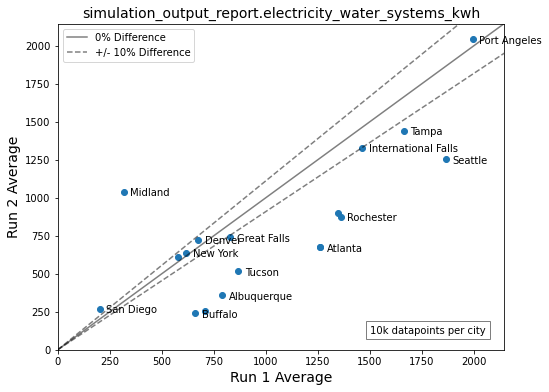

In [133]:
enduse = 'simulation_output_report.electricity_water_systems_kwh'
scatter_plot(run1, run2, enduse, save_path=None)

## Compare Two Runs - Timeseries

In [11]:
def plot_heatmap(dfs, min_max=None):
    xgrid = np.arange(365) + 1
    # Hours start at 0, length 2
    ygrid = np.arange(24)

    fig, axs = plt.subplots(2,1, figsize=(15,6))
    for df, ax in zip(dfs, axs):
        energy = df['electricity_hvac_kwh']
        energy = energy.values.reshape(24, 365, order='F')
        ax.pcolormesh(xgrid, ygrid, energy)
        fnt=14
        ax.set_xlabel('Day of Year', fontsize=fnt)
        ax.set_ylabel('Hour of Day', fontsize=fnt)
        ax.tick_params(axis='x', labelsize=fnt)
        ax.tick_params(axis='y', labelsize=fnt)
    
    if not min_max:
        min_max = (energy.min(), energy.max())
    
    norm = mc.Normalize(min_max[0], min_max[1])
    cb = fig.colorbar(
        ScalarMappable(norm=norm, cmap="plasma"), 
        orientation = "horizontal"
    )
    

### Tampa Heating

Summary of Changes:
- Heating fuel same
- Heating setpoint similar
- Similar saturation of HPs
- Similar electric furnace and electric BB
- Run 2 has higher average floor area (2066 vs 1996 ft2)
- Different weather files


In [12]:
location_map = {
    'Seattle':'4C', 'Atlanta': '3A', 'Denver': '5B', 'Tucson':'2B', 'New York':'4A', 'San Diego': '3C', 'Tampa': '2A', 
    'Albuquerque':'4B', 'Buffalo':'5A', 'Midland': '3B',
    'Rochester':'6A', 'International Falls': '7', 'Great Falls':'6B', 'Port Angeles':'5C'
}
zone_map = {}
for city, zone in location_map.items():
    zone_map[zone] = city

# Run 1 - Baseline timeseries
hvac_cols = ['electricity_heating_kwh', 'electricity_fans_heating_kwh','electricity_pumps_heating_kwh', 'electricity_fans_cooling_kwh', 'electricity_pumps_cooling_kwh', 'electricity_cooling_kwh']
base_ts1 = pd.read_csv('../ResStock_results/Original_runs/Run_2/Baseline_up00_all.csv')
base_ts1['electricity_hvac_kwh'] = base_ts1[hvac_cols].sum(axis=1)
base_ts1['time'] = pd.to_datetime(base_ts1['time'])
base_ts1['day'] = base_ts1['time'].apply(lambda x: x.day)
base_ts1['hour'] = base_ts1['time'].apply(lambda x: x.hour)
base_ts1['electricity_hvac_kwh'] = base_ts1['electricity_hvac_kwh']*base_ts1['count']

# Run 2 - Baseline Timeseries Average
hvac_cols = ['electricity_heating_kwh', 'electricity_fans_heating_kwh','electricity_pumps_heating_kwh', 'electricity_fans_cooling_kwh', 'electricity_pumps_cooling_kwh', 'electricity_cooling_kwh']
base_ts2 = pd.read_csv('../ResStock_results/FY22_runs/national/timeseries/baseline_ts.csv')
base_ts2['electricity_hvac_kwh'] = base_ts2[hvac_cols].sum(axis=1)
base_ts2['time'] = pd.to_datetime(base_ts2['time'])
base_ts2['day'] = base_ts2['time'].apply(lambda x: x.day)
base_ts2['hour'] = base_ts2['time'].apply(lambda x: x.hour)
base_ts2['month'] = base_ts2['time'].apply(lambda x: x.month)
base_ts1['month'] = base_ts2['month']
base_ts2['electricity_hvac_kwh'] = base_ts2['electricity_hvac_kwh']*base_ts2['count']

#### Rolling Average HVAC Energy

In [13]:
# Orlando + Tampa Weather
from pyepw.epw import EPW
dbt = pd.DataFrame()
epw = EPW()

tmy_path = './orange_co.epw'
tmy_path = './USA_FL_Orlando.Intl.AP.722050_TMY3.epw'
epw.read(tmy_path)
dbt_orlando = []
skycover_orlando = []
for ct, wd in enumerate(epw.weatherdata):
    temp = wd.dry_bulb_temperature
    dbt_orlando.append(temp)
    sky_cover = wd.direct_normal_radiation
    skycover_orlando.append(sky_cover)
    
epw = EPW()
tmy_path = './hillsborough_co.epw'
epw.read(tmy_path)
dbt_tampa = []
skycover_tampa = []
for ct, wd in enumerate(epw.weatherdata):
    temp = wd.dry_bulb_temperature
    dbt_tampa.append(temp)
    sky_cover = wd.direct_normal_radiation
    skycover_tampa.append(sky_cover)

In [113]:
def plot_rolling_avg(cols, labels, window, marker):
    x = range(len(df1))
    for col_data, label in zip(cols, labels):
        plt.plot(x,col_data.rolling(window).mean(), marker, label=label)

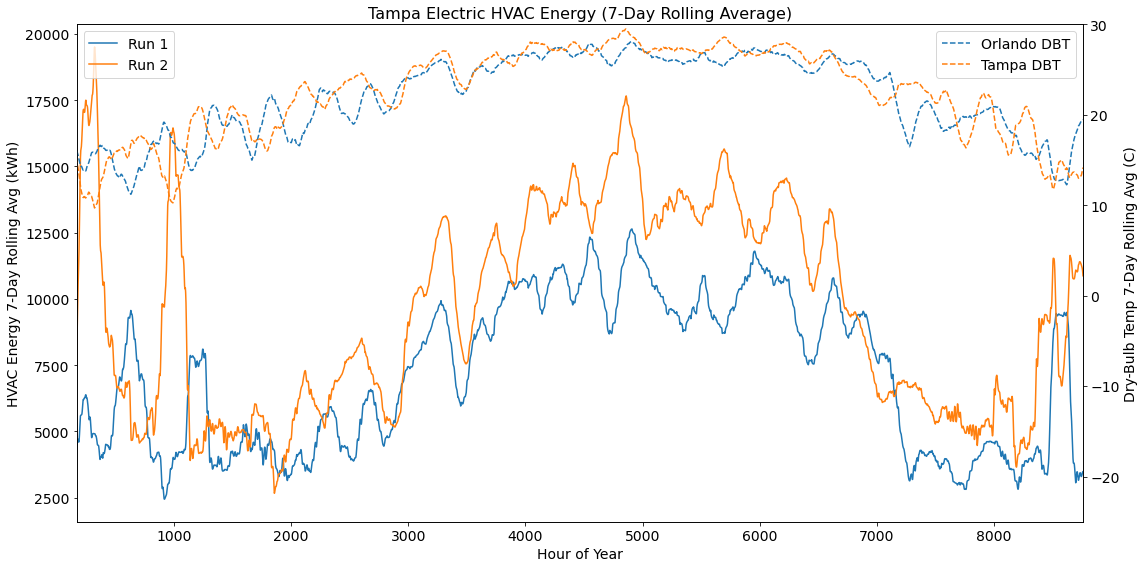

In [137]:
# Rolling Average w/ DBT [FULL YEAR - TAMPA]
city = 'Tampa'
fnt =14
window = 24*7
save_name = None
save_name = 'hvac_energy_7day_rolling_tampa'
save_path = '../Resstock_results/FY22_runs/national/figures/'

fig, ax = plt.subplots(figsize=(16,8))
# HVAC Energy
df1 = base_ts1[base_ts1['city']==city]
df2 = base_ts2[base_ts2['city']==city]
cols = [df1['electricity_hvac_kwh'], df2['electricity_hvac_kwh']]
plot_rolling_avg(cols, ['Run 1', 'Run 2'], window, '-')
ax.legend(fontsize=fnt, loc=2)
ax.set_ylabel(f'HVAC Energy {int(window/24)}-Day Rolling Avg (kWh)', fontsize=fnt)
ax.set_xlabel('Hour of Year', fontsize=fnt)
ax.set_title(city + ' Electric HVAC Energy (7-Day Rolling Average)', fontsize=fnt+2)
ax.tick_params(axis='x', labelsize=fnt)
ax.tick_params(axis='y', labelsize=fnt)

# DBTs
ax2 = ax.twinx()
dfs = [pd.Series(dbt_orlando), pd.Series(dbt_tampa)]
plot_rolling_avg(dfs, ['Orlando DBT', 'Tampa DBT'], window, '--')
ax2.set_ylim(-25,30)
ax2.legend(fontsize=fnt, loc=1)
ax2.set_ylabel(f'Dry-Bulb Temp {int(window/24)}-Day Rolling Avg (C)',fontsize=fnt)
ax2.tick_params(axis='y', labelsize=fnt)
plt.xlim(window,8760)

# Save
plt.tight_layout()
if save_name:
    plt.savefig(os.path.join(save_path, save_name + '.png'), dpi=400, bbox_inches='tight')

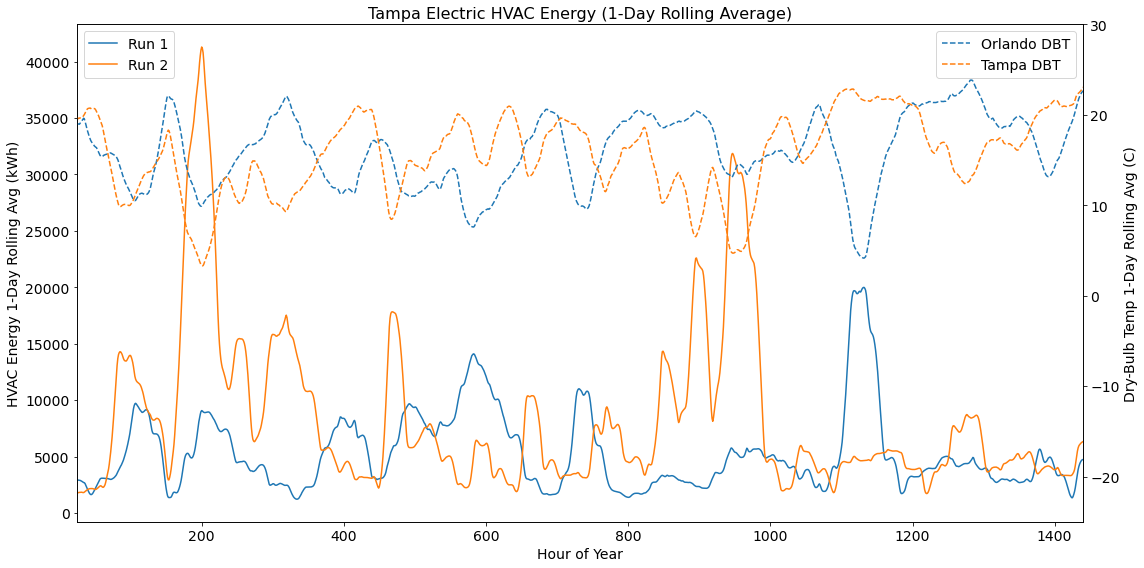

In [138]:
# Rolling 1-Day Average w/ DBT [START OF YEAR - TAMPA]
city = 'Tampa'
fnt =14
window = 24
save_name = None
save_name = 'hvac_energy_1day_rolling_tampa'
save_path = '../Resstock_results/FY22_runs/national/figures/'

fig, ax = plt.subplots(figsize=(16,8))
# HVAC Energy
df1 = base_ts1[base_ts1['city']==city]
df2 = base_ts2[base_ts2['city']==city]
cols = [df1['electricity_hvac_kwh'], df2['electricity_hvac_kwh']]
plot_rolling_avg(cols, ['Run 1', 'Run 2'], window, '-')
ax.legend(fontsize=fnt, loc=2)
ax.set_ylabel(f'HVAC Energy {int(window/24)}-Day Rolling Avg (kWh)', fontsize=fnt)
ax.set_xlabel('Hour of Year', fontsize=fnt)
ax.set_title(city + ' Electric HVAC Energy (1-Day Rolling Average)', fontsize=fnt+2)
ax.tick_params(axis='x', labelsize=fnt)
ax.tick_params(axis='y', labelsize=fnt)

# DBTs
ax2 = ax.twinx()
dfs = [pd.Series(dbt_orlando), pd.Series(dbt_tampa)]
plot_rolling_avg(dfs, ['Orlando DBT', 'Tampa DBT'], window, '--')
ax2.set_ylim(-25,30)
ax2.legend(fontsize=fnt, loc=1)
ax2.set_ylabel(f'Dry-Bulb Temp {int(window/24)}-Day Rolling Avg (C)',fontsize=fnt)
ax2.tick_params(axis='y', labelsize=fnt)
plt.xlim(window,24*60)

# Save
plt.tight_layout()
if save_name:
    plt.savefig(os.path.join(save_path, save_name + '.png'), dpi=400, bbox_inches='tight')

#### Monthly Average

In [146]:
def plot_monthly(dfs, ax):
    y1 = dfs[0].groupby('month').sum()['electricity_hvac_kwh']
    y2 = dfs[1].groupby('month').sum()['electricity_hvac_kwh']
    x = range(1,len(y1)+1,1)
    
    ax.plot(x, y1, '.-', label='Run 1')
    ax.plot(x, y2, '.-', label='Run 2')
    
    ax.set_xticks(range(2,13,2))
    ax.set_xlabel('Month')
    fnt =14

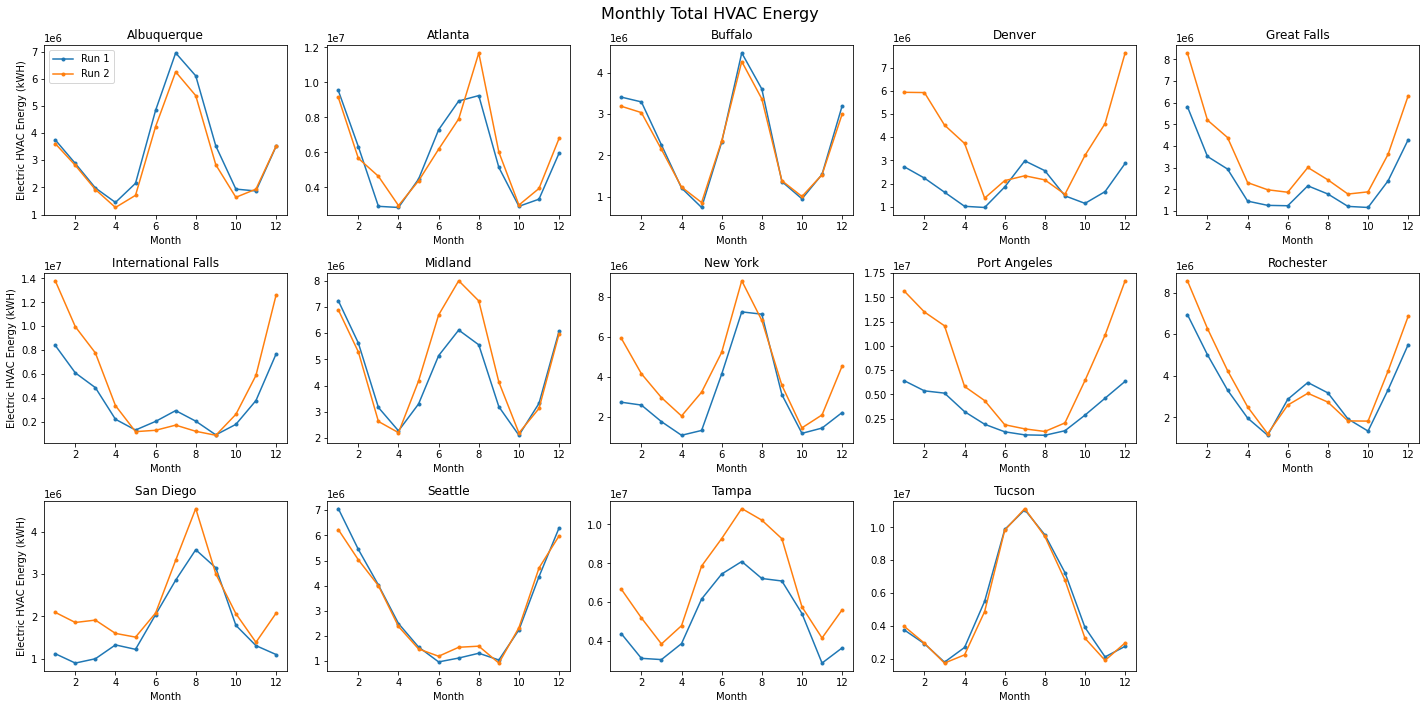

In [147]:
cities = ['Seattle', 'Atlanta_1', 'Denver', 'Tucson', 'New York_1', 'San Diego', 'Tampa', 'Albuquerque', 'Buffalo_1', 'Midland', 'Rochester_1','International Falls', 'Great Falls', 'Port Angeles']
cities.sort()
save_name = None
save_name = 'hvac_energy_monthly_all'
save_path = '../Resstock_results/FY22_runs/national/figures/'

# fig, axs = plt.subplots(2,int(len(cities)/2),figsize=(25,6))
fig, axs = plt.subplots(3,5,figsize=(20,10))

for i, (city, ax) in enumerate(zip(cities, fig.axes)):
    df1 = base_ts1[base_ts1['city']==city]
    df2 = base_ts2[base_ts2['city']==city]
    dfs = [df1, df2]
    plot_monthly(dfs, ax)
    city = city.split('_')[0]
    ax.set_title(city, fontsize=12)
    if city == cities[0]:
        ax.legend(loc=2)
    if i == 0 or i == 5 or i == 10:
        ax.set_ylabel('Electric HVAC Energy (kWH)')

axs[-1, -1].axis('off')
# axs[-1, -2].axis('off')

fig.suptitle('Monthly Total HVAC Energy', fontsize=16)
plt.tight_layout()
if save_name:
    plt.savefig(os.path.join(save_path, save_name + '.png'), dpi=400, bbox_inches='tight')

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
No handles with labels found to put in legend.


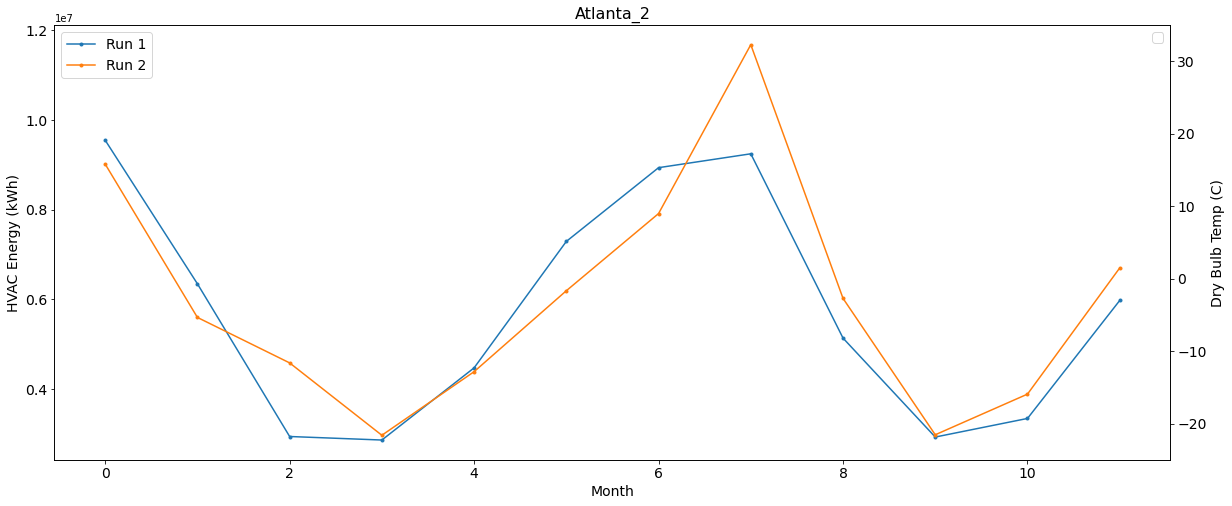

In [612]:
# Monthly + DBT
city = 'Tampa'
fnt =14
df1 = base_ts1[base_ts1['city']==city]
df2 = base_ts2[base_ts2['city']==city]
df1['dbt'] = dbt_orlando
df2['dbt'] = dbt_tampa

x = range(len(df1.groupby('month').sum()))
window = 24*7

fig, ax = plt.subplots(figsize=(20,8))
plt.plot(x,df1.groupby('month').sum()['electricity_hvac_kwh'], '.-', label='Run 1')
plt.plot(x,df2.groupby('month').sum()['electricity_hvac_kwh'], '.-', label='Run 2')
plt.legend(fontsize=fnt, loc=2)
plt.ylabel('HVAC Energy (kWh)', fontsize=fnt)
plt.xlabel('Month', fontsize=fnt)
plt.title(city, fontsize=fnt+2)
ax.tick_params(axis='x', labelsize=fnt)
ax.tick_params(axis='y', labelsize=fnt)

ax2 = ax.twinx()
ax2.set_ylim(-25,35)
ax2.plot(x,df1.groupby('month').mean()['dbt'], '.--', label='Orlando')
ax2.plot(x,df2.groupby('month').mean()['dbt'], '.--', label='Tampa')
ax2.legend(fontsize=fnt, loc=1)
ax2.set_ylabel('Dry Bulb Temp (C)',fontsize=fnt)
ax2.tick_params(axis='y', labelsize=fnt)

In [571]:
# Change in Heating Setpoint
city = 'Tampa'
# city = None
params = ['build_existing_model.heating_setpoint']
# params = ['build_existing_model.infiltration']
# params = ['build_existing_model.insulation_wall']
# params = ['build_existing_model.vintage']
# params = ['build_existing_model.heating_fuel']
# params = ['build_existing_model.hvac_system_heating_electricity', 'build_existing_model.hvac_heating_efficiency']
# params = ['build_existing_model.hvac_system_heat_pump', 'build_existing_model.hvac_heating_efficiency']
# params = ['simulation_output_report.floor_area_conditioned_ft_2']

param_filter = [('build_existing_model.heating_fuel', ['Electricity'])]
# param_filter=[]

print(city)
# df=get_input_counts([run1, run2], ['run 1', 'run 2'], params, city, param_filters=param_filter).sort_index()
df=get_input_counts([run1, run2], ['run 1', 'run 2'], params, city, param_filters=param_filter).sort_index()
df

# enduse = 'simulation_output_report.electricity_heating_kwh'
# param_filter = [('build_existing_model.heating_fuel', ['Electricity'])]
# plot_histogram([run1, run2], params[0], ['run 1', 'run 2'], param_filters=param_filter, threshold=0, bins=20, city=city, save_path=None)
# df

cmus = ['CMU, 6-in Hollow, R-11','CMU, 6-in Hollow, R-15','CMU, 6-in Hollow, R-19','CMU, 6-in Hollow, R-7','CMU, 6-in Hollow, Uninsulated',
        'Brick, 12-in, 3-wythe, R-11','Brick, 12-in, 3-wythe, R-15','Brick, 12-in, 3-wythe, R-19','Brick, 12-in, 3-wythe, R-7','Brick, 12-in, 3-wythe, Uninsulated']
df.loc[cmus].sum()

Tampa


,run 1,run 2
55F,NaN,0.079
60F,0.025,0.032
62F,0.006,0.006
65F,0.067,0.056
67F,0.024,0.027
68F,0.170,0.173
70F,0.239,0.219
72F,0.158,0.147
75F,0.175,0.138
76F,0.049,0.046


### Cold Climate ASHP Upgrade

Need:
    1) Run 1 sum of baseline HVAC Energy ts
    2) Run 1 ASHP upgraded energy; Run 1 CAC baseline energy; Run 1 Other baseline energy
    2) Run 2 sum of baseline HVAC Energy ts

In [139]:
location_map = {
    'Seattle':'4C', 'Atlanta_1': '3A', 'Atlanta_2': '3A', 'Denver': '5B', 'Tucson':'2B', 'New York_1':'4A', 'New York_2':'4A', 'San Diego': '3C', 'Tampa': '2A', 
    'Albuquerque':'4B', 'Buffalo_1':'5A', 'Buffalo_2':'5A', 'Midland': '3B',
    'Rochester_1':'6A', 'Rochester_2':'6A', 'International Falls': '7', 'Great Falls':'6B', 'Port Angeles':'5C'}

hvac_cols = ['electricity_heating_kwh', 'electricity_fans_heating_kwh','electricity_pumps_heating_kwh', 'electricity_fans_cooling_kwh', 'electricity_pumps_cooling_kwh', 'electricity_cooling_kwh']
    
    
# Run 1
## ASHP Energy
up_ts1 = pd.read_csv('../ResStock_results/Original_runs/Run_2/Upgrades_ts.csv')
up_ts1 = up_ts1[up_ts1['upgrade']==2]
up_ts1['electricity_hvac_kwh'] = up_ts1[hvac_cols].sum(axis=1)
up_ts1['electricity_hvac_kwh'] = up_ts1['electricity_hvac_kwh']*up_ts1['count']
## CAC Base Energy
base_ts1_cac = pd.read_csv('../ResStock_results/Original_runs/Run_2/Baseline_up01_CAC.csv')
base_ts1_cac['electricity_hvac_kwh'] = base_ts1_cac[hvac_cols].sum(axis=1)
base_ts1_cac['electricity_hvac_kwh'] = base_ts1_cac['electricity_hvac_kwh']*base_ts1_cac['count']
## ASHP Base Energy
base_ts1_ashp = pd.read_csv('../ResStock_results/Original_runs/Run_2/Baseline_up02_ASHP.csv')
base_ts1_ashp['electricity_hvac_kwh'] = base_ts1_ashp[hvac_cols].sum(axis=1)
base_ts1_ashp['electricity_hvac_kwh'] = base_ts1_ashp['electricity_hvac_kwh']*base_ts1_ashp['count']
## Other Base Energy
base_ts1_other = pd.read_csv('../ResStock_results/Original_runs/Run_2/Baseline_up08_other.csv')
base_ts1_other['electricity_hvac_kwh'] = base_ts1_other[hvac_cols].sum(axis=1)
base_ts1_other['electricity_hvac_kwh'] = base_ts1_other['electricity_hvac_kwh']*base_ts1_other['count']

run_1_base = base_ts1_cac.copy()
run_1_base['electricity_hvac_kwh'] = base_ts1_cac['electricity_hvac_kwh'] + base_ts1_ashp['electricity_hvac_kwh'] + base_ts1_other['electricity_hvac_kwh']
run_1_base['zone'] = run_1_base['city'].map(location_map)
run_1_w_ashp = base_ts1_cac.copy()
run_1_w_ashp['electricity_hvac_kwh'] = base_ts1_cac['electricity_hvac_kwh'].values + up_ts1['electricity_hvac_kwh'].values + base_ts1_other['electricity_hvac_kwh'].values
run_1_w_ashp['zone'] = run_1_w_ashp['city'].map(location_map)

# Run 2
## ASHP Energy
up_ts2 = pd.read_csv('../ResStock_results/FY22_runs/national/timeseries/upgrades_ts.csv')
up_ts2 = up_ts2[up_ts2['upgrade']==2]
up_ts2['electricity_hvac_kwh'] = up_ts2[hvac_cols].sum(axis=1)
up_ts2['electricity_hvac_kwh'] = up_ts2['electricity_hvac_kwh']*up_ts2['count']

## CAC Base Energy
base_ts2_cac = pd.read_csv('../ResStock_results/FY22_runs/national/timeseries/baseline_cac_ts.csv')
base_ts2_cac['electricity_hvac_kwh'] = base_ts2_cac[hvac_cols].sum(axis=1)
base_ts2_cac['electricity_hvac_kwh'] = base_ts2_cac['electricity_hvac_kwh']*base_ts2_cac['count']
## ASHP Base Energy
base_ts2_ashp = pd.read_csv('../ResStock_results/FY22_runs/national/timeseries/baseline_ashp_ts.csv')
base_ts2_ashp['electricity_hvac_kwh'] = base_ts2_ashp[hvac_cols].sum(axis=1)
base_ts2_ashp['electricity_hvac_kwh'] = base_ts2_ashp['electricity_hvac_kwh']*base_ts2_ashp['count']
## Other Base Energy
base_ts2_other = pd.read_csv('../ResStock_results/FY22_runs/national/timeseries/baseline_other_ts.csv')
base_ts2_other['electricity_hvac_kwh'] = base_ts2_other[hvac_cols].sum(axis=1)
base_ts2_other['electricity_hvac_kwh'] = base_ts2_other['electricity_hvac_kwh']*base_ts2_other['count']

run_2_base = base_ts2_cac.copy()
run_2_base['electricity_hvac_kwh'] = base_ts2_cac['electricity_hvac_kwh'] + base_ts2_ashp['electricity_hvac_kwh'] + base_ts2_other['electricity_hvac_kwh']
run_2_base['zone'] = run_2_base['city'].map(location_map)
run_2_w_ashp = base_ts2_cac.copy()
run_2_w_ashp['electricity_hvac_kwh'] = base_ts2_cac['electricity_hvac_kwh'].values + up_ts2['electricity_hvac_kwh'].values + base_ts2_other['electricity_hvac_kwh'].values
run_2_w_ashp['zone'] = run_2_w_ashp['city'].map(location_map)


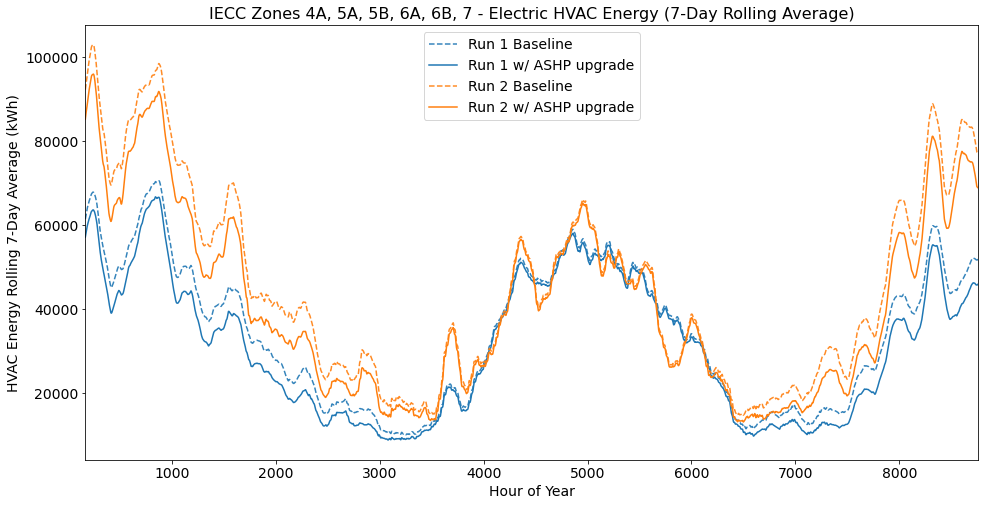

In [153]:
save_name = None
save_name = 'hvac_energy_coldclimates_ASHP'
save_path = '../Resstock_results/FY22_runs/national/figures/'

cities = ['International Falls', 'Great Falls', 'Rochester_1', 'Rochester_2', 'New York_1', 'New York_2', 'Buffalo_1', 'Buffalo_2', 'Denver']
cities = ['International Falls', 'Great Falls', 'Rochester_1', 'Rochester_2', 'New York_1', 'New York_2', 'Buffalo_1', 'Buffalo_2', 'Denver']
zones = ['4A', '5A', '5B', '6A', '6B', '7']
rolling_days = 7
fig, ax = plt.subplots(figsize=(16,8))
## Run 1
# df1 = run_1_base[run_1_base['city'].isin(cities)].groupby('time').sum()
# df2 = run_1_w_ashp[run_1_w_ashp['city'].isin(cities)].groupby('time').sum()
df1 = run_1_base[run_1_base['zone'].isin(zones)].groupby('time').sum()
df2 = run_1_w_ashp[run_1_w_ashp['zone'].isin(zones)].groupby('time').sum()
line1, = plt.plot(x,df1['electricity_hvac_kwh'].rolling(24*rolling_days).mean(), '--', alpha=.9, label='Run 1 Baseline')
plt.plot(x,df2['electricity_hvac_kwh'].rolling(24*rolling_days).mean(), '-', color=line1.get_color(), label='Run 1 w/ ASHP upgrade')

## Run 2
# df1 = run_2_base[run_2_base['city'].isin(cities)].groupby('time').sum()
# df2 = run_2_w_ashp[run_2_w_ashp['city'].isin(cities)].groupby('time').sum()
df1 = run_2_base[run_2_base['zone'].isin(zones)].groupby('time').sum()
df2 = run_2_w_ashp[run_2_w_ashp['zone'].isin(zones)].groupby('time').sum()
line2, = plt.plot(x,df1['electricity_hvac_kwh'].rolling(24*rolling_days).mean(), '--', alpha=.9, label='Run 2 Baseline')
plt.plot(x,df2['electricity_hvac_kwh'].rolling(24*rolling_days).mean(), '-', color=line2.get_color(), label='Run 2 w/ ASHP upgrade')

## Plt inputs
plt.legend(fontsize=fnt)
plt.ylabel('HVAC Energy Rolling 7-Day Average (kWh)', fontsize=fnt)
plt.xlabel('Hour of Year', fontsize=fnt)
plt.title(cities, fontsize=fnt+2)
plt.title(f'IECC Zones {", ".join(zones)} - Electric HVAC Energy (7-Day Rolling Average)', fontsize=fnt+2)

plt.xlim(24*rolling_days, 8760)
ax.tick_params(axis='x', labelsize=fnt)
ax.tick_params(axis='y', labelsize=fnt)

if save_name:
    plt.savefig(os.path.join(save_path, save_name + '.png'), dpi=400, bbox_inches='tight')

In [ ]:
city = 'Tampa'
df1 = base_ts1[base_ts1['city']==city]
df2 = base_ts2[base_ts2['city']==city]

min_max = (base_ts1['electricity_hvac_kwh'].min(), base_ts1['electricity_hvac_kwh'].max())
plot_heatmap([df1,df2])

# df = base_ts2[base_ts2['city']==city]
# plot_heatmap(df)
# plot_heatmap(df, min_max)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


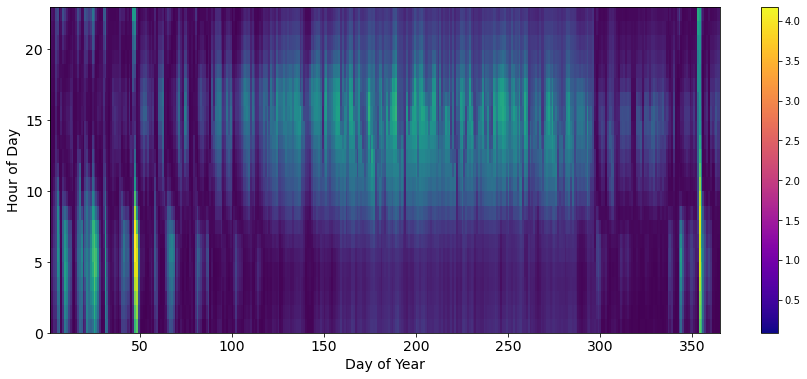

In [185]:
city = 'Tampa'
df = base_ts2[base_ts2['city']==city]
plot_heatmap(df)

In [69]:
run1_dir = './output_csvs/Run_2_11.24.20/savings_shape/'
run2_dir = './output_csvs/FY22/savings_shape/'
upgrade = 'P1b_Best_ASHP'
upgrade = 'P1a_Best_CAC'

run1_ts = pd.read_csv(os.path.join(run1_dir, upgrade+'.csv'))
run1_ts['City'] = run1_ts['Climate Zone'].map(zone_map)
dup_cities = run1_ts[run1_ts['Net Load Version']==2]['City'].unique()
run1_ts.loc[run1_ts['City'].isin(dup_cities), 'City'] = run1_ts[run1_ts['City'].isin(dup_cities)]['City'] + '_' + run1_ts[run1_ts['City'].isin(dup_cities)]['Net Load Version'].astype(str)
run1_ts['Diff'] = run1_ts['Baseline Load'] - run1_ts['Measure Load'] 

run2_ts = pd.read_csv(os.path.join(run2_dir, upgrade+'.csv'))
run2_ts['City'] = run2_ts['Climate Zone'].map(zone_map)
run2_ts.loc[run2_ts['City'].isin(dup_cities), 'City'] = run2_ts[run2_ts['City'].isin(dup_cities)]['City'] + '_' + run2_ts[run2_ts['City'].isin(dup_cities)]['Net Load Version'].astype(str)
run2_ts['Diff'] = run2_ts['Baseline Load'] - run2_ts['Measure Load']



## Check TS data

In [4]:
p2_SA = pd.read_csv('./output_csvs/Sens_analysis/savings_shape/P1_upgrade_2_DR.csv')
p2_base = pd.read_csv('./output_csvs/Run_2_11.24.20/savings_shape/P2_DR_thermostat.csv')
p2_DR = pd.read_csv('./output_csvs/DR_package_2/savings_shape/P2_DR_thermostat.csv')

In [11]:
cz = '2A'
enduse = 'cooling'

df0 = p2_base[(p2_base['End Use'] == enduse) & (p2_base['Climate Zone'] == cz)]
df1 = p2_DR[(p2_DR['End Use'] == enduse) & (p2_DR['Climate Zone'] == cz)]
df2 = p2_SA[(p2_SA['End Use'] == enduse) & (p2_SA['Climate Zone'] == cz)]

# df1=p2_base
# df2=p2_SA

In [16]:
(df1['Baseline Load'].mean() - df2['Baseline Load'].mean())/df1['Baseline Load'].mean()

8.739607541035511e-06

In [17]:
(df0['Baseline Load'].mean() - df2['Baseline Load'].mean())/df0['Baseline Load'].mean()

-0.00044448382017903744

In [32]:
results_dir = './output_csvs/FY22/savings_shape/'
ts_dfs = {}
for file in os.listdir(results_dir):
    key = file.split('.')[0]
    ts_dfs[key]= pd.read_csv(os.path.join(results_dir, file))

MemoryError: Unable to allocate 4.81 MiB for an array with shape (2, 315360) and data type int64

In [37]:
ts_dfs['P1a_Best_CAC']

,Hour of Year,Climate Zone,Net Load Version,Building Type,End Use,Baseline Load,Measure Load,Relative Savings
0,1,4B,1,SFD Home,cooling,0.032854,0.050004,7.454939e-06
1,2,4B,1,SFD Home,cooling,0.032846,0.050001,7.456963e-06
2,3,4B,1,SFD Home,cooling,0.032843,0.050000,7.457977e-06
3,4,4B,1,SFD Home,cooling,0.032860,0.050005,7.452926e-06
4,5,4B,1,SFD Home,cooling,0.032855,0.050004,7.454350e-06
...,...,...,...,...,...,...,...,...
157675,8756,2B,1,SFD Home,cooling,0.037728,0.015301,-4.559869e-06
157676,8757,2B,1,SFD Home,cooling,0.020352,0.008170,-2.476988e-06
157677,8758,2B,1,SFD Home,cooling,0.011736,0.004414,-1.488828e-06
157678,8759,2B,1,SFD Home,cooling,0.004869,0.001865,-6.107647e-07


In [44]:
df.head()

,Hour of Year,Climate Zone,Net Load Version,Building Type,End Use,Baseline Load,Measure Load,Relative Savings


In [56]:
df = ts_dfs['P1b_Best_ASHP']
df = df[(df['Climate Zone'] == cz) & (df['End Use'] == enduse)]
df

,Hour of Year,Climate Zone,Net Load Version,Building Type,End Use,Baseline Load,Measure Load,Relative Savings
297840,1,2B,1,SFD Home,heating,0.584494,0.574134,-0.000009
297841,2,2B,1,SFD Home,heating,0.660402,0.636045,-0.000020
297842,3,2B,1,SFD Home,heating,0.735079,0.715436,-0.000016
297843,4,2B,1,SFD Home,heating,0.795149,0.779763,-0.000013
297844,5,2B,1,SFD Home,heating,0.877949,0.893871,0.000013
...,...,...,...,...,...,...,...,...
306595,8756,2B,1,SFD Home,heating,0.022520,0.012071,-0.000009
306596,8757,2B,1,SFD Home,heating,0.049326,0.030228,-0.000016
306597,8758,2B,1,SFD Home,heating,0.083926,0.056648,-0.000022
306598,8759,2B,1,SFD Home,heating,0.143118,0.106495,-0.000030


In [54]:
df['End Use'].unique()

array(['heating', 'cooling'], dtype=object)

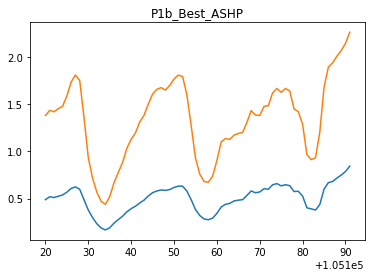

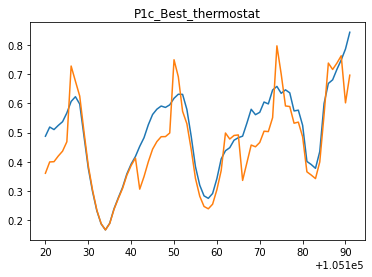

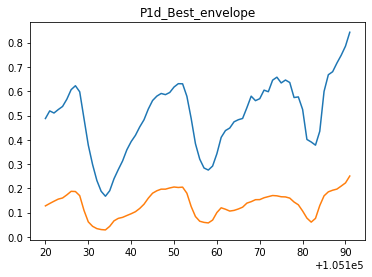

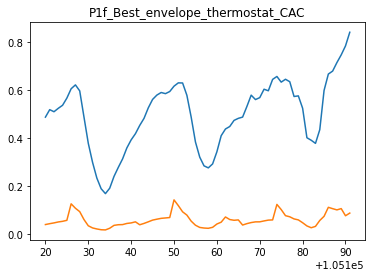

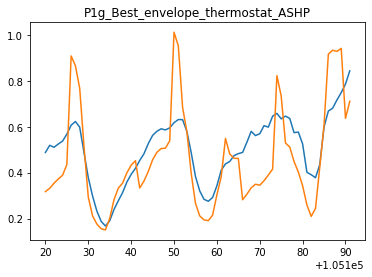

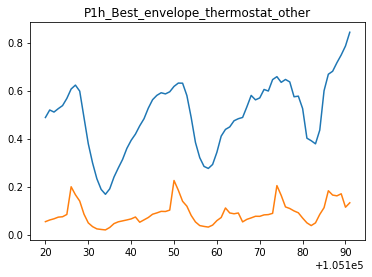

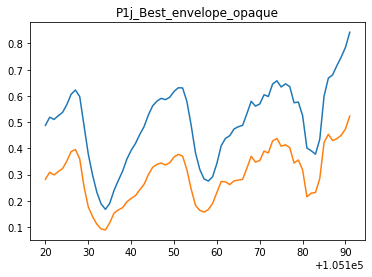

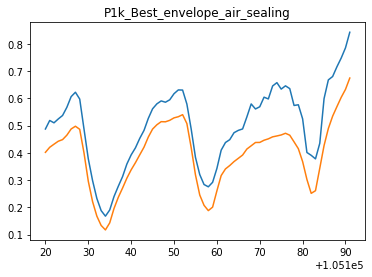

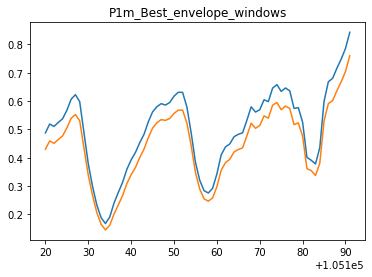

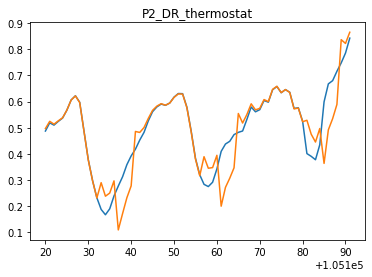

In [62]:
cz = '6B'
enduse = 'heating'
for k, df in ts_dfs.items():
    if enduse not in df['End Use'].unique():
        continue
    df = df[(df['Climate Zone'] == cz) & (df['End Use'] == enduse)]
    plt.figure()
    plt.plot(df['Baseline Load'].iloc[:72])
    plt.plot(df['Measure Load'].iloc[:72])    
    plt.title(k)

In [36]:
ts_dfs.keys()

dict_keys(['P1a_Best_CAC', 'P1b_Best_ASHP', 'P1c_Best_thermostat', 'P1d_Best_envelope', 'P1e_Best_clothes_dryer', 'P1e_Best_clothes_washer', 'P1e_Best_dishwasher', 'P1e_Best_electronics', 'P1e_Best_lighting', 'P1e_Best_pool_pump', 'P1e_Best_refrigerator', 'P1e_Best_waterheater', 'P1f_Best_envelope_thermostat_CAC', 'P1g_Best_envelope_thermostat_ASHP', 'P1h_Best_envelope_thermostat_other', 'P1j_Best_envelope_opaque', 'P1k_Best_envelope_air_sealing', 'P1m_Best_envelope_windows', 'P2_DR_clothes_dryer', 'P2_DR_clothes_washer', 'P2_DR_dishwasher', 'P2_DR_electronics', 'P2_DR_pool_pump', 'P2_DR_thermostat', 'P2_DR_waterheater'])

#============================================================#

## Misc

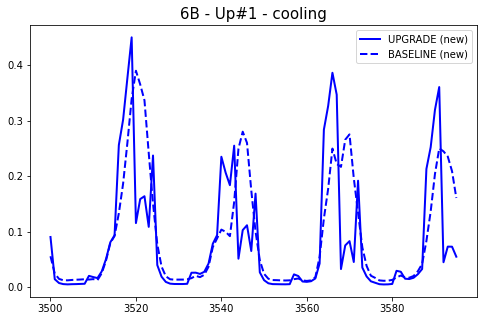

In [61]:
df = saving_shape_dict['upgrade_5_ASHP_ICT']
enduse = 'cooling'
cz = '6B'
hrs = 96

if 'heating' in enduse:
    start = 300
    new_base = base_ts_electricheat.copy() #base_ts_electricheat #base_ts_all
elif 'cooling' in enduse:
    start = 3500
    new_base = base_ts_all.copy()

df = saving_shape_dict['upgrade_1_ICT_precond']
df = df[(df['End Use']==enduse) & (df['Climate Zone']==cz)]
fig, axs = plt.subplots(1,1,figsize=(8,5), sharey=True)

plt.plot(df.iloc[start:start+hrs]['Measure Load'], 'b', label = 'UPGRADE (new)', linewidth=2)
plt.plot(df.iloc[start:start+hrs]['Baseline Load'], 'b--', label='BASELINE (new)', linewidth=2)
plt.title(f'{cz} - Up#{up} - {enduse}', fontsize=15)
plt.legend()

#COOLING OG:   All electric HVAC
#COOLING NEW:  All homes (decrease on average cool)

#HEATING OG:   Match upgrade (electric hvac)
#HEATING NEW:  Electric heating (increase avg elec heating kwh)

In [26]:
df = saving_shape_dict['upgrade_1_ICT_precond']
for df in saving_shape_dict.values():
    print(df['End Use'].unique())


['heating' 'cooling']
['heating' 'cooling']
['heating' 'cooling']
['heating' 'cooling']
['heating' 'cooling']


In [ ]:
#Query for ts out with expanded enduses
params = ['total_site_electricity_kwh',
'electricity_heating_kwh',
'electricity_central_system_heating_kwh',
'electricity_cooling_kwh',
'electricity_central_system_cooling_kwh',
'electricity_water_systems_kwh',
'electricity_interior_lighting_kwh',
'electricity_exterior_lighting_kwh',
'electricity_interior_equipment_kwh',
'electricity_fans_heating_kwh',
'electricity_fans_cooling_kwh',
'electricity_pumps_heating_kwh',
'electricity_pumps_cooling_kwh',
'electricity_central_system_pumps_heating_kwh',
'electricity_central_system_pumps_cooling_kwh',
'electricity_clothes_washer_kwh',
'electricity_clothes_dryer_kwh',
'electricity_dishwasher_kwh',
'electricity_refrigerator_kwh',
'electricity_cooking_range_kwh',
'electricity_extra_refrigerator_kwh',
'electricity_freezer_kwh',
'electricity_plug_loads_kwh',
'electricity_house_fan_kwh',
'electricity_range_fan_kwh',
'electricity_bath_fan_kwh',
'electricity_ceiling_fan_kwh',
'electricity_hot_tub_heater_kwh',
'electricity_hot_tub_pump_kwh',
'electricity_pool_heater_kwh',
'electricity_pool_pump_kwh',
'electricity_well_pump_kwh',
'electricity_garage_lighting_kwh',
'electricity_exterior_holiday_lighting_kwh']

for p in params:
    print(f'avg("geb_full_run2_timeseries"."{p}") AS "{p}",')


In [ ]:
col_map = pd.read_excel('../Resstock_results/Run_2/enduse_col_map.xlsx', usecols=[0,1])
col_map_dict = pd.Series(col_map.enduse_header.values, index=col_map.enduse).to_dict()
df = df.rename(columns=col_map_dict)
df.to_csv('../Resstock_results/Run_2/baseline_electric_enduses_header.csv')